### Predictive Modeling on Hospital Readmission :

### Data Importing 

In [1]:
import pandas as pd

In [2]:
admissions = pd.read_csv('ADMISSIONS.csv')

In [3]:
admissions = admissions.drop(columns=['ROW_ID','ADMISSION_LOCATION','DISCHARGE_LOCATION', 
                                                                          'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
                                                                          'ETHNICITY','EDREGTIME','EDOUTTIME',
                                                                          'DIAGNOSIS','HAS_CHARTEVENTS_DATA',
                                     'DEATHTIME','INSURANCE','HOSPITAL_EXPIRE_FLAG'])

In [4]:
admissions.count()

SUBJECT_ID        58976
HADM_ID           58976
ADMITTIME         58976
DISCHTIME         58976
ADMISSION_TYPE    58976
dtype: int64

In [5]:
# First, convert the ADMITTIME and DISCHTIME columns to datetime format
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], errors='coerce')
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'], errors='coerce')

# Calculate the length of stay as the difference between 'DISCHTIME' and 'ADMITTIME'
admissions['LEN_OF_STAY'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.days
admissions.head()

# Display the relevant columns with length of stay
#sorted_df = merge_notes_diag_proc_adm_df.sort_values(by='LEN_OF_STAY', ascending=False)
#sorted_df.head(30)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,3
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,10
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,7
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,2
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,16


In [6]:
# Remove records where LEN_OF_STAY is less than 0
admissions = admissions[admissions['LEN_OF_STAY'] >= 0]

In [7]:
admissions.count()

SUBJECT_ID        58878
HADM_ID           58878
ADMITTIME         58878
DISCHTIME         58878
ADMISSION_TYPE    58878
LEN_OF_STAY       58878
dtype: int64

In [8]:
# A readmission occurs if a patient's next admission is within 30 days of their previous discharge
admissions['Previous_DISCHTIME'] = admissions.groupby('SUBJECT_ID')['DISCHTIME'].shift(1)

admissions['Readmission'] = (admissions['ADMITTIME'] - admissions['Previous_DISCHTIME']).dt.days <= 60
admissions['Readmission'] = admissions['Readmission'].fillna(False)

admissions.head()
# Calculate the number of readmissions for each SUBJECT_ID
#admissions['Num_Readmissions'] = admissions.groupby('SUBJECT_ID')['Readmission'].cumsum()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,3,NaT,False
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,10,NaT,False
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,7,NaT,False
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,2,NaT,False
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,16,NaT,False


In [9]:
readmission_true = admissions[admissions['Readmission'] == True]
admission_type_counts = readmission_true['ADMISSION_TYPE'].value_counts()
print(admission_type_counts)

ADMISSION_TYPE
EMERGENCY    4373
ELECTIVE      334
URGENT        100
NEWBORN        34
Name: count, dtype: int64


In [10]:
# Filter to keep only SUBJECT_IDs with at least one True in Readmission
subject_ids_with_readmission = admissions.groupby('SUBJECT_ID')['Readmission'].transform('any')

# Use this filter to keep only the relevant rows
admissions_filtered = admissions[subject_ids_with_readmission]

# Display the result to confirm the filtering worked as expected
admissions_filtered.head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission
35,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,NaT,False
36,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True
37,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,ELECTIVE,10,2131-05-25 13:30:00,False
68,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,EMERGENCY,19,NaT,False
69,68,108329,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True


In [11]:
admissions_filtered.count()

SUBJECT_ID            10918
HADM_ID               10918
ADMITTIME             10918
DISCHTIME             10918
ADMISSION_TYPE        10918
LEN_OF_STAY           10918
Previous_DISCHTIME     7374
Readmission           10918
dtype: int64

### Merge Patients.csv to get the age -->

In [12]:
patients = pd.read_csv('PATIENTS.csv')

In [13]:
admissions = pd.merge(admissions_filtered, patients, on=['SUBJECT_ID'], how='inner')

In [14]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10918 entries, 0 to 10917
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          10918 non-null  int64         
 1   HADM_ID             10918 non-null  int64         
 2   ADMITTIME           10918 non-null  datetime64[ns]
 3   DISCHTIME           10918 non-null  datetime64[ns]
 4   ADMISSION_TYPE      10918 non-null  object        
 5   LEN_OF_STAY         10918 non-null  int64         
 6   Previous_DISCHTIME  7374 non-null   datetime64[ns]
 7   Readmission         10918 non-null  bool          
 8   ROW_ID              10918 non-null  int64         
 9   GENDER              10918 non-null  object        
 10  DOB                 10918 non-null  object        
 11  DOD                 6193 non-null   object        
 12  DOD_HOSP            4583 non-null   object        
 13  DOD_SSN             5176 non-null   object    

In [15]:
admissions = admissions.drop(columns=['ROW_ID','DOD_HOSP','DOD_SSN'])

In [16]:
from datetime import datetime

admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], errors='coerce')
admissions['DOB'] = pd.to_datetime(admissions['DOB'], errors='coerce')

# Function to calculate age in years
def calculate_age(dob, admittime):
    # Return the difference in years accounting for whether the birthday has occurred yet this year
    age = admittime.year - dob.year - ((admittime.month, admittime.day) < (dob.month, dob.day))
    return age

# Apply the function across the DataFrame
admissions['AGE'] = admissions.apply(lambda x: calculate_age(x['DOB'], x['ADMITTIME']), axis=1)

# Display the first few rows to confirm the age calculation
admissions.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,NaT,False,M,2061-08-17,NaN,0,69
1,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True,M,2061-08-17,NaN,0,69
2,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,ELECTIVE,10,2131-05-25 13:30:00,False,M,2061-08-17,NaN,0,72
3,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,EMERGENCY,19,NaT,False,F,2132-02-29,2174-02-11 00:00:00,1,41
4,68,108329,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41
5,103,130744,2144-08-12 17:37:00,2144-08-20 11:15:00,EMERGENCY,7,NaT,False,F,2084-04-14,2144-09-01 00:00:00,1,60
6,103,133550,2144-08-30 23:09:00,2144-09-01 14:28:00,EMERGENCY,1,2144-08-20 11:15:00,True,F,2084-04-14,2144-09-01 00:00:00,1,60
7,105,161160,2189-01-28 16:57:00,2189-02-02 16:40:00,EMERGENCY,4,NaT,False,F,2153-09-26,2190-02-15 00:00:00,1,35
8,105,128744,2189-02-21 01:45:00,2189-02-25 10:05:00,EMERGENCY,4,2189-02-02 16:40:00,True,F,2153-09-26,2190-02-15 00:00:00,1,35
9,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,EMERGENCY,16,NaT,False,F,2117-08-07,2142-08-30 00:00:00,1,20


### Trying only For admission_type = EMERGENCY and URGENT

In [17]:
admissions = admissions[admissions['ADMISSION_TYPE'].isin(['EMERGENCY', 'URGENT'])]
admissions.reset_index(drop=True, inplace=True)
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,NaT,False,M,2061-08-17,NaN,0,69
1,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True,M,2061-08-17,NaN,0,69
2,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,EMERGENCY,19,NaT,False,F,2132-02-29,2174-02-11 00:00:00,1,41
3,68,108329,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41
4,103,130744,2144-08-12 17:37:00,2144-08-20 11:15:00,EMERGENCY,7,NaT,False,F,2084-04-14,2144-09-01 00:00:00,1,60


In [18]:
admissions.count()

SUBJECT_ID            9617
HADM_ID               9617
ADMITTIME             9617
DISCHTIME             9617
ADMISSION_TYPE        9617
LEN_OF_STAY           9617
Previous_DISCHTIME    6774
Readmission           9617
GENDER                9617
DOB                   9617
DOD                   5742
EXPIRE_FLAG           9617
AGE                   9617
dtype: int64

In [19]:
readmission_true = admissions[admissions['Readmission'] == True]
admission_type_counts = readmission_true['ADMISSION_TYPE'].value_counts()
print(admission_type_counts)

ADMISSION_TYPE
EMERGENCY    4373
URGENT        100
Name: count, dtype: int64


In [20]:
# Filter the DataFrame to only include rows where Readmission is True
readmission_true_records = admissions[admissions['Readmission'] == True]

# Display a sample of these records
readmission_true_records.count()


SUBJECT_ID            4473
HADM_ID               4473
ADMITTIME             4473
DISCHTIME             4473
ADMISSION_TYPE        4473
LEN_OF_STAY           4473
Previous_DISCHTIME    4473
Readmission           4473
GENDER                4473
DOB                   4473
DOD                   2646
EXPIRE_FLAG           4473
AGE                   4473
dtype: int64

# Procedure data fetch

In [21]:
proc = pd.read_csv('PROCEDURES_ICD.csv')
proc.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,331


In [22]:
proc.count()

ROW_ID        240095
SUBJECT_ID    240095
HADM_ID       240095
SEQ_NUM       240095
ICD9_CODE     240095
dtype: int64

In [23]:
proc = proc.rename(columns={'ICD9_CODE': 'PROC_ICD9_CODE'})

In [24]:
# Step 1: Prepare the diagnosis DataFrame
# Convert ICD9_CODE to string and replace NaNs with an empty string
proc['PROC_ICD9_CODE'] = proc['PROC_ICD9_CODE'].fillna('').astype(str)

# Group by SUBJECT_ID and HADM_ID, then concatenate the ICD9_CODEs
proc_aggregated = proc.groupby(['SUBJECT_ID', 'HADM_ID'])['PROC_ICD9_CODE'].agg('|'.join).reset_index()

# Rename columns to match the output specification
proc_aggregated.columns = ['SUBJECT_ID', 'HADM_ID', 'PROC_ICD9_CODE']

# Step 2: Merge the aggregated diagnosis DataFrame with the admissions DataFrame
# Perform an inner join on SUBJECT_ID and HADM_ID
admissions = pd.merge(admissions,proc_aggregated, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
admissions.count()

SUBJECT_ID            8232
HADM_ID               8232
ADMITTIME             8232
DISCHTIME             8232
ADMISSION_TYPE        8232
LEN_OF_STAY           8232
Previous_DISCHTIME    5737
Readmission           8232
GENDER                8232
DOB                   8232
DOD                   5015
EXPIRE_FLAG           8232
AGE                   8232
PROC_ICD9_CODE        8232
dtype: int64

In [25]:
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,NaT,False,M,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872
1,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904
2,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,EMERGENCY,19,NaT,False,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9910|9904|9912
3,68,108329,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915
4,103,130744,2144-08-12 17:37:00,2144-08-20 11:15:00,EMERGENCY,7,NaT,False,F,2084-04-14,2144-09-01 00:00:00,1,60,159


# Drug Codes Import 

In [26]:
drug = pd.read_csv('DRGCODES.csv')
drug.head()

,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,342,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,344,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,345,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,346,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN


In [27]:
drug = drug[['SUBJECT_ID', 'HADM_ID', 'DRG_CODE']]

In [28]:
# Step 1: Prepare the diagnosis DataFrame
# Convert ICD9_CODE to string and replace NaNs with an empty string
drug['DRG_CODE'] = drug['DRG_CODE'].fillna('').astype(str)

# Group by SUBJECT_ID and HADM_ID, then concatenate the ICD9_CODEs
drug_aggregated = drug.groupby(['SUBJECT_ID', 'HADM_ID'])['DRG_CODE'].agg('|'.join).reset_index()
drug_aggregated.count()

SUBJECT_ID    58890
HADM_ID       58890
DRG_CODE      58890
dtype: int64

In [29]:
# Step 2: Merge the aggregated diagnosis DataFrame with the admissions DataFrame
# Perform an inner join on SUBJECT_ID and HADM_ID
admissions = pd.merge(admissions,drug_aggregated, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
admissions.count()

SUBJECT_ID            8226
HADM_ID               8226
ADMITTIME             8226
DISCHTIME             8226
ADMISSION_TYPE        8226
LEN_OF_STAY           8226
Previous_DISCHTIME    5735
Readmission           8226
GENDER                8226
DOB                   8226
DOD                   5010
EXPIRE_FLAG           8226
AGE                   8226
PROC_ICD9_CODE        8226
DRG_CODE              8226
dtype: int64

In [30]:
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,NaT,False,M,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652
1,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912
2,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,EMERGENCY,19,NaT,False,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9910|9904|9912,8924|489
3,68,108329,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489
4,103,130744,2144-08-12 17:37:00,2144-08-20 11:15:00,EMERGENCY,7,NaT,False,F,2084-04-14,2144-09-01 00:00:00,1,60,159,1


### Diagnosis Data Importing and cleaning

In [31]:
diagnosis = pd.read_csv('DIAGNOSES_ICD.csv')

In [32]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [33]:
diagnosis = diagnosis.drop(columns=['ROW_ID','SEQ_NUM'])

In [34]:
diagnosis.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE
0,109,172335,40301
1,109,172335,486
2,109,172335,58281
3,109,172335,5855
4,109,172335,4254


In [35]:
diagnosis.count()

SUBJECT_ID    651047
HADM_ID       651047
ICD9_CODE     651000
dtype: int64

In [36]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   SUBJECT_ID  651047 non-null  int64 
 1   HADM_ID     651047 non-null  int64 
 2   ICD9_CODE   651000 non-null  object
dtypes: int64(2), object(1)
memory usage: 14.9+ MB


In [37]:
diagnosis['ICD9_CODE'] = diagnosis['ICD9_CODE'].astype(str) # Remove records where ICD9_CODE starts with 'E' or 'V' 
diagnosis = diagnosis[~diagnosis['ICD9_CODE'].str.startswith(('E', 'V'))]
diagnosis.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE
0,109,172335,40301
1,109,172335,486
2,109,172335,58281
3,109,172335,5855
4,109,172335,4254


In [38]:
diagnosis.count()

SUBJECT_ID    553798
HADM_ID       553798
ICD9_CODE     553798
dtype: int64

# ICD9_CODE Categorization

In [39]:
def truncate_icd9_code(icd_code):
    # Check if the code is a string and starts with a digit
    if pd.notna(icd_code) and icd_code[0].isdigit():
        return icd_code[:3]
    else:
        return None  # Return None for non-numeric or NaN values

# Apply the function to truncate the codes
diagnosis['truncated_icd9'] = diagnosis['ICD9_CODE'].apply(truncate_icd9_code)


In [40]:
# Function to categorize truncated ICD9 codes
def categorize_icd9(code):
    if code is None:
        return None
    try:
        code_num = int(code)
    except ValueError:
        return None  # In case there's an error in conversion

    if 1 <= code_num <= 139:
        return "Infectious and Parasitic Diseases"
    elif 140 <= code_num <= 239:
        return "Neoplasms"
    elif 240 <= code_num <= 279 or 710 <= code_num <= 739:
        return "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases"
    elif 280 <= code_num <= 289:
        return "Diseases of the Blood and Blood-forming Organs"
    elif 290 <= code_num <= 319 or 320 <= code_num <= 389:
        return "Diseases of the Nervous System and Mental Disorders"
    elif 390 <= code_num <= 459:
        return "Diseases of the Circulatory System"
    elif 460 <= code_num <= 519:
        return "Diseases of the Respiratory System"
    elif 520 <= code_num <= 579:
        return "Diseases of the Digestive System"
    elif 580 <= code_num <= 629:
        return "Diseases of the Genitourinary System"
    elif 630 <= code_num <= 679:
        return "Complications of Pregnancy, Childbirth, and the Puerperium"
    elif 680 <= code_num <= 709:
        return "Diseases of the Skin and Subcutaneous Tissue"
    elif 740 <= code_num <= 759:
        return "Congenital Anomalies"
    elif 760 <= code_num <= 779:
        return "Certain Conditions originating in the Perinatal Period"
    elif 780 <= code_num <= 799:
        return "Symptoms, Signs and Ill-defined Conditions"
    elif 800 <= code_num <= 999:
        return "Injury and Poisoning"
    else:
        return "Other"  # Return None if the code doesn't match any category

# Apply the categorization function
diagnosis['diagnosis_category'] = diagnosis['truncated_icd9'].apply(categorize_icd9)

In [41]:
diagnosis['diagnosis_category'].value_counts()

diagnosis_category
Diseases of the Circulatory System                                                                     140257
Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases     82984
Diseases of the Nervous System and Mental Disorders                                                     48210
Diseases of the Respiratory System                                                                      44825
Injury and Poisoning                                                                                    42948
Diseases of the Digestive System                                                                        38527
Diseases of the Genitourinary System                                                                    32867
Symptoms, Signs and Ill-defined Conditions                                                              29691
Diseases of the Blood and Blood-forming Organs                                                       

In [42]:
# Display the updated DataFrame
diagnosis.count()

SUBJECT_ID            553798
HADM_ID               553798
ICD9_CODE             553798
truncated_icd9        553751
diagnosis_category    553751
dtype: int64

In [43]:
# Remove records where diagnosis_category is 'Complications of Pregnancy, Childbirth, and the Puerperium' 
diagnosis = diagnosis[diagnosis['diagnosis_category'] != 'Complications of Pregnancy, Childbirth, and the Puerperium']
diagnosis = diagnosis[diagnosis['diagnosis_category'] != 'Congenital Anomalies']
diagnosis = diagnosis[diagnosis['diagnosis_category'] != 'Neoplasms']
diagnosis = diagnosis[diagnosis['diagnosis_category'] != 'Diseases of the Skin and Subcutaneous Tissue']
diagnosis.count()

SUBJECT_ID            526042
HADM_ID               526042
ICD9_CODE             526042
truncated_icd9        525995
diagnosis_category    525995
dtype: int64

In [44]:
diagnosis['diagnosis_category'].value_counts()

diagnosis_category
Diseases of the Circulatory System                                                                     140257
Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases     82984
Diseases of the Nervous System and Mental Disorders                                                     48210
Diseases of the Respiratory System                                                                      44825
Injury and Poisoning                                                                                    42948
Diseases of the Digestive System                                                                        38527
Diseases of the Genitourinary System                                                                    32867
Symptoms, Signs and Ill-defined Conditions                                                              29691
Diseases of the Blood and Blood-forming Organs                                                       

In [45]:
# Define the function to remove duplicate entries within the diagnosis_category string
def remove_duplicates(diagnosis_str):
    unique_diagnoses = set(diagnosis_str.split('|'))  # Split by '|' and convert to a set to remove duplicates
    return '|'.join(unique_diagnoses)  # Join back into a single string

# Step 1: Prepare the diagnosis DataFrame
# Convert ICD9_CODE to string and replace NaNs with an empty string
diagnosis['diagnosis_category'] = diagnosis['diagnosis_category'].fillna('').astype(str)

# Group by SUBJECT_ID and HADM_ID, then concatenate the ICD9_CODEs
diagnosis_aggregated = diagnosis.groupby(['SUBJECT_ID', 'HADM_ID'])['diagnosis_category'].agg('|'.join).reset_index()

# Apply the remove_duplicates function to the diagnosis_category column
diagnosis_aggregated['diagnosis_category'] = diagnosis_aggregated['diagnosis_category'].apply(remove_duplicates)

# Rename columns to match the output specification
diagnosis_aggregated.columns = ['SUBJECT_ID', 'HADM_ID', 'diagnosis_category']

# Step 2: Merge the aggregated diagnosis DataFrame with the admissions DataFrame
# Perform an inner join on SUBJECT_ID and HADM_ID
diagnosis_aggregated_df = pd.merge(admissions, diagnosis_aggregated, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
diagnosis_aggregated_df.head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,NaT,False,M,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,Diseases of the Circulatory System|Diseases of...
1,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...
2,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,EMERGENCY,19,NaT,False,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9910|9904|9912,8924|489,"Diseases of the Circulatory System|Endocrine, ..."
3,68,108329,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ..."
4,103,130744,2144-08-12 17:37:00,2144-08-20 11:15:00,EMERGENCY,7,NaT,False,F,2084-04-14,2144-09-01 00:00:00,1,60,159,1,"Diseases of the Circulatory System|Endocrine, ..."


In [46]:
diagnosis_aggregated_df.to_csv('diagnosis_categories.csv')

### NOTE EVENTS DATA MERGE WITH DIAGNOSIS AND ADMISSION TABLE

In [47]:
file_path = r'C:\Users\gaurk\Desktop\PYTHON_JUPYTER\606 CAPSTONE\Data Cleaning Week 5\NOTEEVENTS.CSV'
print(file_path)

C:\Users\gaurk\Desktop\PYTHON_JUPYTER\606 CAPSTONE\Data Cleaning Week 5\NOTEEVENTS.CSV


In [48]:
notes_df = pd.read_csv('NOTEEVENTS.CSV', low_memory=False)

In [49]:
notes_df = notes_df.drop(columns=['CHARTDATE','CHARTTIME', 'STORETIME', 'CGID', 'ISERROR'])
notes_df.count()

ROW_ID         2083180
SUBJECT_ID     2083180
HADM_ID        1851344
CATEGORY       2083180
DESCRIPTION    2083180
TEXT           2083180
dtype: int64

In [50]:
notes_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT
0,174,22532,167853.0,Discharge summary,Report,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,Discharge summary,Report,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,Discharge summary,Report,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,Discharge summary,Report,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,Discharge summary,Report,Admission Date: [**2162-3-3**] D...
5,179,53181,170490.0,Discharge summary,Report,Admission Date: [**2172-3-5**] D...
6,180,20646,134727.0,Discharge summary,Report,Admission Date: [**2112-12-8**] ...
7,181,42130,114236.0,Discharge summary,Report,Admission Date: [**2150-2-25**] ...
8,182,56174,163469.0,Discharge summary,Report,Admission Date: [**2118-8-10**] ...
9,183,56174,189681.0,Discharge summary,Report,Admission Date: [**2118-12-7**] ...


In [51]:
# Count the occurrences of each category
category_counts = notes_df['CATEGORY'].value_counts()

# Display the results
print(category_counts)

CATEGORY
Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: count, dtype: int64


In [52]:
#notes_df.info()

In [53]:
notes_df = notes_df.sort_values(by=['SUBJECT_ID', 'HADM_ID'], ascending=True)

In [54]:
#notes_df.count()

In [55]:
#notes_df.nunique()

In [56]:
#category_counts = notes_df['CATEGORY'].value_counts()
#print(category_counts)

In [57]:
notes_df.count()

ROW_ID         2083180
SUBJECT_ID     2083180
HADM_ID        1851344
CATEGORY       2083180
DESCRIPTION    2083180
TEXT           2083180
dtype: int64

### Only trying on Discharge summary for now, we can check remaining later. 

In [58]:
discharge_summary_df = notes_df.loc[notes_df['CATEGORY'] == 'Discharge summary']
discharge_summary_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT
48470,44005,3,145834.0,Discharge summary,Report,Admission Date: [**2101-10-20**] Discharg...
4782,4788,4,185777.0,Discharge summary,Report,Admission Date: [**2191-3-16**] Discharge...
24476,20825,6,107064.0,Discharge summary,Report,Admission Date: [**2175-5-30**] Dischar...
22764,20070,9,150750.0,Discharge summary,Report,Admission Date: [**2149-11-9**] Dischar...
57341,57115,9,150750.0,Discharge summary,Addendum,"Name: [**Known lastname 10050**], [**Known fi..."


In [59]:
#discharge_summary_df.to_csv('discharge_summary_df.csv', index=False)

In [60]:
discharge_summary_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT
48470,44005,3,145834.0,Discharge summary,Report,Admission Date: [**2101-10-20**] Discharg...
4782,4788,4,185777.0,Discharge summary,Report,Admission Date: [**2191-3-16**] Discharge...
24476,20825,6,107064.0,Discharge summary,Report,Admission Date: [**2175-5-30**] Dischar...
22764,20070,9,150750.0,Discharge summary,Report,Admission Date: [**2149-11-9**] Dischar...
57341,57115,9,150750.0,Discharge summary,Addendum,"Name: [**Known lastname 10050**], [**Known fi..."


In [61]:
import pandas as pd

notes_diagnosis_adm_df = discharge_summary_df.merge(diagnosis_aggregated_df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
notes_diagnosis_adm_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category
0,7413,36,122659.0,Discharge summary,Report,Admission Date: [**2131-5-12**] ...,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...
1,7412,36,182104.0,Discharge summary,Report,Admission Date: [**2131-4-30**] ...,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,NaT,False,M,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,Diseases of the Circulatory System|Diseases of...
2,9139,68,108329.0,Discharge summary,Report,Admission Date: [**2174-1-4**] D...,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ..."
3,56004,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ..."
4,56002,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ..."


In [62]:
# Filter the DataFrame to only include rows where Readmission is True
notes_diagnosis_adm_df_true = notes_diagnosis_adm_df[notes_diagnosis_adm_df['Readmission'] == True]

# Display a sample of these records
notes_diagnosis_adm_df_true.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,Previous_DISCHTIME,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category
0,7413,36,122659.0,Discharge summary,Report,Admission Date: [**2131-5-12**] ...,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,2131-05-08 14:00:00,True,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...
2,9139,68,108329.0,Discharge summary,Report,Admission Date: [**2174-1-4**] D...,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ..."
3,56004,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ..."
4,56002,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,2174-01-03 18:30:00,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ..."
7,14859,109,102024.0,Discharge summary,Report,Admission Date: [**2142-5-20**] ...,2142-05-20 12:59:00,2142-06-05 16:18:00,EMERGENCY,16,2142-05-18 15:58:00,True,F,2117-08-07,2142-08-30 00:00:00,1,24,4516|3995|481|9904|9907,4604|4604|682,"Diseases of the Circulatory System|Endocrine, ..."


In [63]:
from collections import Counter

# Split the diagnosis_category values by '|'
all_categories = notes_diagnosis_adm_df_true['diagnosis_category'].str.split('|').tolist()

# Flatten the list of lists and count occurrences of each category
category_counts = Counter([category for sublist in all_categories for category in sublist])

# Create a DataFrame for the counts and sort by count
category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count']).reset_index()
category_counts_df.rename(columns={'index': 'Category'}, inplace=True)
category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)

# Display the counts for each category
print(category_counts_df)

                                             Category  Count
0                  Diseases of the Circulatory System   3685
5   Endocrine, Nutritional and Metabolic Diseases,...   3349
1                  Diseases of the Respiratory System   2656
4                Diseases of the Genitourinary System   2439
9   Diseases of the Nervous System and Mental Diso...   2159
2                    Diseases of the Digestive System   2105
3                                Injury and Poisoning   2083
6      Diseases of the Blood and Blood-forming Organs   2011
7                   Infectious and Parasitic Diseases   2007
8          Symptoms, Signs and Ill-defined Conditions   1995
10  Certain Conditions originating in the Perinata...    127


In [64]:
# Filter the DataFrame to only include rows where Readmission is True
notes_diagnosis_adm_df.count()

ROW_ID                9220
SUBJECT_ID            9220
HADM_ID               9220
CATEGORY              9220
DESCRIPTION           9220
TEXT                  9220
ADMITTIME             9220
DISCHTIME             9220
ADMISSION_TYPE        9220
LEN_OF_STAY           9220
Previous_DISCHTIME    6313
Readmission           9220
GENDER                9220
DOB                   9220
DOD                   5770
EXPIRE_FLAG           9220
AGE                   9220
PROC_ICD9_CODE        9220
DRG_CODE              9220
diagnosis_category    9220
dtype: int64

In [65]:
notes_diagnosis_adm_df.to_csv('check_labels.csv')

In [66]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download stopwords and punkt tokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
 # Remove PHI placeholders like [**data**]
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    # Remove dosage/frequency patterns (like mg, ml, q.d., b.i.d., etc.)
    text = re.sub(r'\b(mg|ml|cc|b.i.d.|q.d.|q.4-6h|p.o.|t.i.d.|u.d.)\b', '', text)
    # Remove numbers (e.g., dates, job numbers)
    text = re.sub(r'\d+', '', text)
    # Remove medical measurements (e.g., cm, mmHg, bpm)
    text = re.sub(r'\b(cm|mm|mmhg|bpm|iu|l|mgdl|kg)\b', '', text)
    # Remove specific section headers like "DISCHARGE STATUS" or "PHYSICAL EXAM"
    # Lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Remove extra whitespaces
    return ' '.join(tokens)

# Apply the function to your 'TEXT' column
notes_diagnosis_adm_df['cleaned_text'] = notes_diagnosis_adm_df['TEXT'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SnehalChoudhari-
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SnehalChoudhari-
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SnehalChoudhari-
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [67]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\SnehalChoudhari-
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [68]:
# Convert 'AGE' column to absolute values and then to integers
if 'AGE' in notes_diagnosis_adm_df.columns:
    notes_diagnosis_adm_df['AGE'] = notes_diagnosis_adm_df['AGE'].abs().astype(int)


In [69]:
notes_diagnosis_adm_df.Readmission.value_counts()

Readmission
False    4952
True     4268
Name: count, dtype: int64

In [70]:
notes_diagnosis_adm_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,...,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category,cleaned_text
0,7413,36,122659.0,Discharge summary,Report,Admission Date: [**2131-5-12**] ...,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,...,True,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...
1,7412,36,182104.0,Discharge summary,Report,Admission Date: [**2131-4-30**] ...,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,...,False,M,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...
2,9139,68,108329.0,Discharge summary,Report,Admission Date: [**2174-1-4**] D...,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",admission date discharge date date birth sex f...
3,56004,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...
4,56002,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...


In [71]:
# notes_diagnosis_adm_df.to_csv('obj2_final_df.csv')

In [72]:
# notes_diagnosis_adm_df= pd.read_csv('obj2_final_df.csv')

In [73]:
result_df = notes_diagnosis_adm_df.copy()

In [74]:
result_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,...,Readmission,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category,cleaned_text
0,7413,36,122659.0,Discharge summary,Report,Admission Date: [**2131-5-12**] ...,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,...,True,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...
1,7412,36,182104.0,Discharge summary,Report,Admission Date: [**2131-4-30**] ...,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,...,False,M,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...
2,9139,68,108329.0,Discharge summary,Report,Admission Date: [**2174-1-4**] D...,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",admission date discharge date date birth sex f...
3,56004,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...
4,56002,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,True,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...


In [75]:
result_df.count()

ROW_ID                9220
SUBJECT_ID            9220
HADM_ID               9220
CATEGORY              9220
DESCRIPTION           9220
TEXT                  9220
ADMITTIME             9220
DISCHTIME             9220
ADMISSION_TYPE        9220
LEN_OF_STAY           9220
Previous_DISCHTIME    6313
Readmission           9220
GENDER                9220
DOB                   9220
DOD                   5770
EXPIRE_FLAG           9220
AGE                   9220
PROC_ICD9_CODE        9220
DRG_CODE              9220
diagnosis_category    9220
cleaned_text          9220
dtype: int64

# "Past 6 Months Hospital Admission" and "Past 6 Months ED Admission"

In [76]:
import pandas as pd

# Path to your ADMISSIONS.csv file on Google Drive
file_path = 'ADMISSIONS.csv'

# Load the dataset
admissions_data = pd.read_csv(file_path)

# Convert ADMITTIME and DISCHTIME to datetime if not already done
admissions_data['ADMITTIME'] = pd.to_datetime(admissions_data['ADMITTIME'], errors='coerce')
admissions_data['DISCHTIME'] = pd.to_datetime(admissions_data['DISCHTIME'], errors='coerce')

# Sort data by patient ID and admission time to ensure sequential ordering
admissions_data = admissions_data.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])

# Calculate "Past 6 Months Hospital Admission" variable
admissions_data['Past_6_Months_Hospital_Admission'] = admissions_data.groupby('SUBJECT_ID').apply(
    lambda group: group['ADMITTIME'].apply(
        lambda x: ((group['DISCHTIME'] < x) &
                   (group['DISCHTIME'] >= x - pd.Timedelta(days=180))).sum()
    )
).reset_index(level=0, drop=True)

# # Calculate "Past 6 Months ED Admission" variable
# admissions_data['Past_6_Months_ED_Admission'] = admissions_data.groupby('SUBJECT_ID').apply(
#     lambda group: group['ADMITTIME'].apply(
#         lambda x: ((group['ADMISSION_TYPE'] == 'EMERGENCY') &
#                    (group['DISCHTIME'] < x) &
#                    (group['DISCHTIME'] >= x - pd.Timedelta(days=180))).sum()
#     )
# ).reset_index(level=0, drop=True)


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\1869262792.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  admissions_data['Past_6_Months_Hospital_Admission'] = admissions_data.groupby('SUBJECT_ID').apply(


In [77]:
combined_df = pd.merge(result_df, admissions_data[['SUBJECT_ID', 'HADM_ID',
                                                                     'Past_6_Months_Hospital_Admission',
                                                                     ]],
                       on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [78]:
combined_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,...,GENDER,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category,cleaned_text,Past_6_Months_Hospital_Admission
0,7413,36,122659.0,Discharge summary,Report,Admission Date: [**2131-5-12**] ...,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,...,M,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...,1
1,7412,36,182104.0,Discharge summary,Report,Admission Date: [**2131-4-30**] ...,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,...,M,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...,0
2,9139,68,108329.0,Discharge summary,Report,Admission Date: [**2174-1-4**] D...,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",admission date discharge date date birth sex f...,1
3,56004,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...,1
4,56002,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,F,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...,1


In [79]:
combined_df.count()

ROW_ID                              9220
SUBJECT_ID                          9220
HADM_ID                             9220
CATEGORY                            9220
DESCRIPTION                         9220
TEXT                                9220
ADMITTIME                           9220
DISCHTIME                           9220
ADMISSION_TYPE                      9220
LEN_OF_STAY                         9220
Previous_DISCHTIME                  6313
Readmission                         9220
GENDER                              9220
DOB                                 9220
DOD                                 5770
EXPIRE_FLAG                         9220
AGE                                 9220
PROC_ICD9_CODE                      9220
DRG_CODE                            9220
diagnosis_category                  9220
cleaned_text                        9220
Past_6_Months_Hospital_Admission    9220
dtype: int64

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust the number of features based on the dataset

# Apply the TF-IDF transformation to the 'cleaned_text' column
X_text = tfidf_vectorizer.fit_transform(combined_df['cleaned_text'])

# Check the shape of the resulting matrix (number of documents, number of features)
print(X_text.shape)

(9220, 10000)


In [81]:

from sklearn.preprocessing import MultiLabelBinarizer

# Splitting the diagnosis_category entries into lists of labels
combined_df['label_list'] = combined_df['diagnosis_category'].map(lambda x: x.split('|'))

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the labels into a binary matrix
Y = mlb.fit_transform(combined_df['label_list'])

# Check the shape of the output array and the classes
print(Y.shape)
print(mlb.classes_)


(9220, 11)
['Certain Conditions originating in the Perinatal Period'
 'Diseases of the Blood and Blood-forming Organs'
 'Diseases of the Circulatory System' 'Diseases of the Digestive System'
 'Diseases of the Genitourinary System'
 'Diseases of the Nervous System and Mental Disorders'
 'Diseases of the Respiratory System'
 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases'
 'Infectious and Parasitic Diseases' 'Injury and Poisoning'
 'Symptoms, Signs and Ill-defined Conditions']


In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Convert PROC_ICD9_CODE, DRG_CODE from pipe-separated strings to lists of codes
notes_diagnosis_adm_df['PROC_ICD9_CODE'] = notes_diagnosis_adm_df['PROC_ICD9_CODE'].apply(lambda x: x.split('|'))
notes_diagnosis_adm_df['DRG_CODE'] = notes_diagnosis_adm_df['DRG_CODE'].apply(lambda x: x.split('|'))

# Step 2: Encode categorical variables

# Use MultiLabelBinarizer to one-hot encode ICD9_CODE, PROC_ICD9_CODE, DRG_CODE, and CPT_CD
mlb_proc_icd9 = MultiLabelBinarizer()
mlb_drug_code = MultiLabelBinarizer()

proc_icd9_encoded = mlb_proc_icd9.fit_transform(notes_diagnosis_adm_df['PROC_ICD9_CODE'])
drug_code_encoded = mlb_drug_code.fit_transform(notes_diagnosis_adm_df['DRG_CODE'])

# Convert encoded arrays to DataFrames and align indexes
proc_icd9_df = pd.DataFrame(proc_icd9_encoded, columns=mlb_proc_icd9.classes_, index=notes_diagnosis_adm_df.index)
drug_cd_df = pd.DataFrame(drug_code_encoded, columns=mlb_drug_code.classes_, index=notes_diagnosis_adm_df.index)


In [83]:
# Prepare numerical data
# Standardize Numerical Features, including the 6-month admission columns
scaler = StandardScaler()
#X_numerical = scaler.fit_transform(combined_df[['LEN_OF_STAY','Past_6_Months_Hospital_Admission']].fillna(0))
X_numerical = scaler.fit_transform(combined_df[['Past_6_Months_Hospital_Admission']].fillna(0))

In [84]:
# Combine TF-IDF text features with numerical and encoded categorical features
X_combined = hstack([X_text, X_numerical, proc_icd9_df, drug_cd_df])

In [85]:
combined_df.count()

ROW_ID                              9220
SUBJECT_ID                          9220
HADM_ID                             9220
CATEGORY                            9220
DESCRIPTION                         9220
TEXT                                9220
ADMITTIME                           9220
DISCHTIME                           9220
ADMISSION_TYPE                      9220
LEN_OF_STAY                         9220
Previous_DISCHTIME                  6313
Readmission                         9220
GENDER                              9220
DOB                                 9220
DOD                                 5770
EXPIRE_FLAG                         9220
AGE                                 9220
PROC_ICD9_CODE                      9220
DRG_CODE                            9220
diagnosis_category                  9220
cleaned_text                        9220
Past_6_Months_Hospital_Admission    9220
label_list                          9220
dtype: int64

In [86]:
combined_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,...,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category,cleaned_text,Past_6_Months_Hospital_Admission,label_list
0,7413,36,122659.0,Discharge summary,Report,Admission Date: [**2131-5-12**] ...,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,...,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...,1,"[Diseases of the Circulatory System, Diseases ..."
1,7412,36,182104.0,Discharge summary,Report,Admission Date: [**2131-4-30**] ...,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,...,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...,0,"[Diseases of the Circulatory System, Diseases ..."
2,9139,68,108329.0,Discharge summary,Report,Admission Date: [**2174-1-4**] D...,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",admission date discharge date date birth sex f...,1,"[Diseases of the Circulatory System, Endocrine..."
3,56004,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...,1,"[Diseases of the Circulatory System, Endocrine..."
4,56002,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...,1,"[Diseases of the Circulatory System, Endocrine..."


In [87]:
combined_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,ADMITTIME,DISCHTIME,ADMISSION_TYPE,LEN_OF_STAY,...,DOB,DOD,EXPIRE_FLAG,AGE,PROC_ICD9_CODE,DRG_CODE,diagnosis_category,cleaned_text,Past_6_Months_Hospital_Admission,label_list
0,7413,36,122659.0,Discharge summary,Report,Admission Date: [**2131-5-12**] ...,2131-05-12 19:49:00,2131-05-25 13:30:00,EMERGENCY,12,...,2061-08-17,NaN,0,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...,1,"[Diseases of the Circulatory System, Diseases ..."
1,7412,36,182104.0,Discharge summary,Report,Admission Date: [**2131-4-30**] ...,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,8,...,2061-08-17,NaN,0,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,Diseases of the Circulatory System|Diseases of...,admission date discharge date date birth sex s...,0,"[Diseases of the Circulatory System, Diseases ..."
2,9139,68,108329.0,Discharge summary,Report,Admission Date: [**2174-1-4**] D...,2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",admission date discharge date date birth sex f...,1,"[Diseases of the Circulatory System, Endocrine..."
3,56004,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...,1,"[Diseases of the Circulatory System, Endocrine..."
4,56002,68,108329.0,Discharge summary,Addendum,"Name: [**Known lastname 5477**],[**Known firs...",2174-01-04 22:21:00,2174-01-19 11:30:00,EMERGENCY,14,...,2132-02-29,2174-02-11 00:00:00,1,41,3893|9915,8924|489,"Diseases of the Circulatory System|Endocrine, ...",name unit admission date discharge date date b...,1,"[Diseases of the Circulatory System, Endocrine..."


In [88]:
combined_df.count()

ROW_ID                              9220
SUBJECT_ID                          9220
HADM_ID                             9220
CATEGORY                            9220
DESCRIPTION                         9220
TEXT                                9220
ADMITTIME                           9220
DISCHTIME                           9220
ADMISSION_TYPE                      9220
LEN_OF_STAY                         9220
Previous_DISCHTIME                  6313
Readmission                         9220
GENDER                              9220
DOB                                 9220
DOD                                 5770
EXPIRE_FLAG                         9220
AGE                                 9220
PROC_ICD9_CODE                      9220
DRG_CODE                            9220
diagnosis_category                  9220
cleaned_text                        9220
Past_6_Months_Hospital_Admission    9220
label_list                          9220
dtype: int64

In [89]:
combined_df_copy = combined_df.drop(columns=['ROW_ID','SUBJECT_ID','HADM_ID','CATEGORY','DESCRIPTION','TEXT','ADMITTIME','DISCHTIME',
                                             'ADMISSION_TYPE','Previous_DISCHTIME','Readmission', 'DOB',
                                            'DOD','diagnosis_category','EXPIRE_FLAG'])
combined_df_copy.head()

,LEN_OF_STAY,GENDER,AGE,PROC_ICD9_CODE,DRG_CODE,cleaned_text,Past_6_Months_Hospital_Admission,label_list
0,12,M,69,3479|7761|3932|3403|8674|7851|7761|3893|9904,439|7912,admission date discharge date date birth sex s...,1,"[Diseases of the Circulatory System, Diseases ..."
1,8,M,69,3615|3722|3614|8856|8853|8845|3961|8872,548|1652,admission date discharge date date birth sex s...,0,"[Diseases of the Circulatory System, Diseases ..."
2,14,F,41,3893|9915,8924|489,admission date discharge date date birth sex f...,1,"[Diseases of the Circulatory System, Endocrine..."
3,14,F,41,3893|9915,8924|489,name unit admission date discharge date date b...,1,"[Diseases of the Circulatory System, Endocrine..."
4,14,F,41,3893|9915,8924|489,name unit admission date discharge date date b...,1,"[Diseases of the Circulatory System, Endocrine..."


In [90]:
combined_df_copy.count()

LEN_OF_STAY                         9220
GENDER                              9220
AGE                                 9220
PROC_ICD9_CODE                      9220
DRG_CODE                            9220
cleaned_text                        9220
Past_6_Months_Hospital_Admission    9220
label_list                          9220
dtype: int64

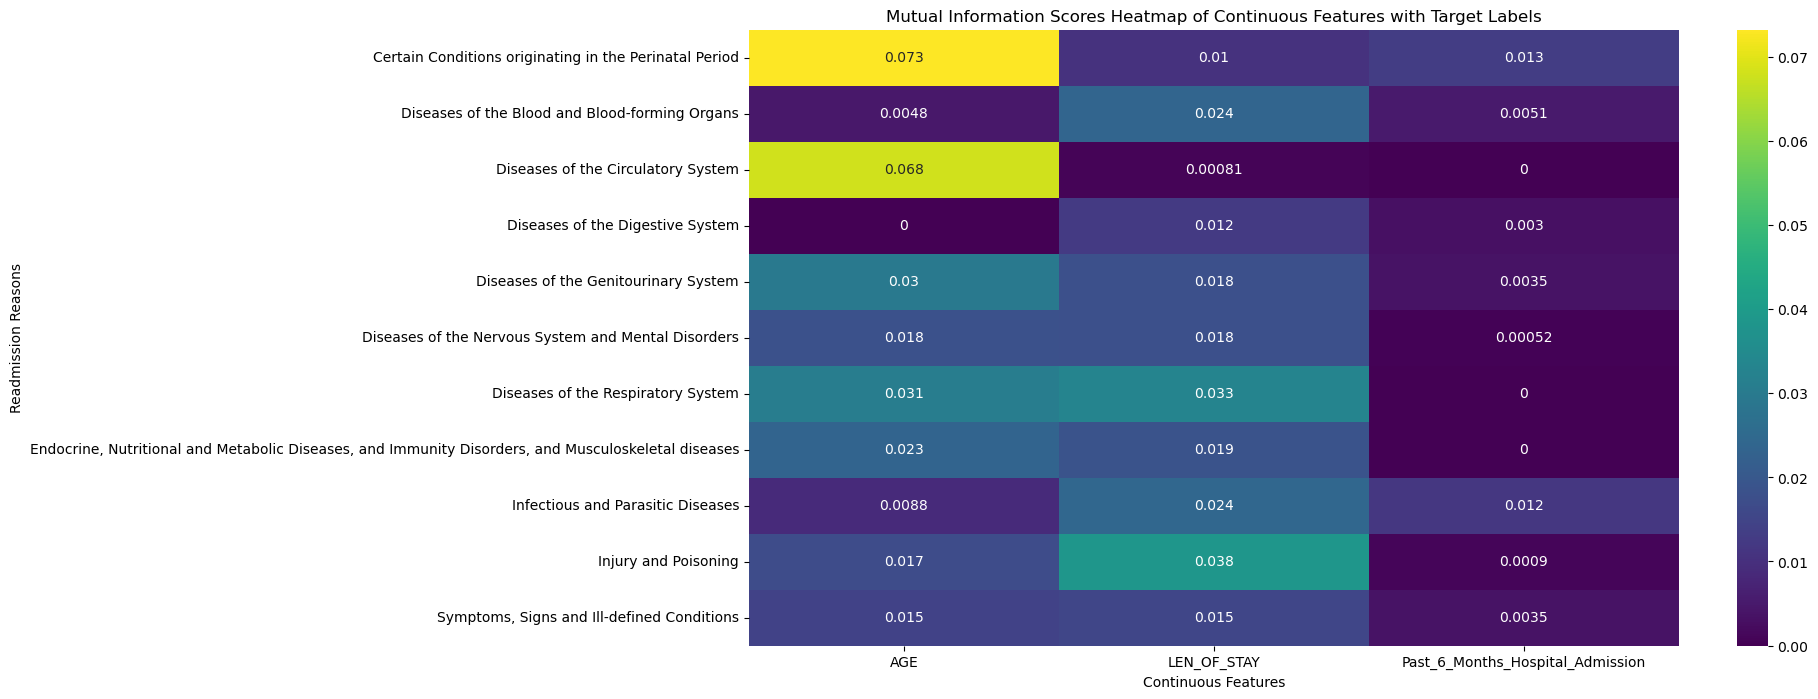

,AGE,LEN_OF_STAY,Past_6_Months_Hospital_Admission
Certain Conditions originating in the Perinatal Period,0.073219,0.010465,0.013056
Diseases of the Blood and Blood-forming Organs,0.004834,0.023705,0.005081
Diseases of the Circulatory System,0.068035,0.000809,0.000000
Diseases of the Digestive System,0.000000,0.012338,0.002998
Diseases of the Genitourinary System,0.029503,0.017941,0.003491
Diseases of the Nervous System and Mental Disorders,0.018019,0.017843,0.000520
Diseases of the Respiratory System,0.030716,0.033043,0.000000
"Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases",0.023185,0.018713,0.000000
Infectious and Parasitic Diseases,0.008846,0.024156,0.011578
Injury and Poisoning,0.016755,0.038461,0.000895


In [91]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the feature matrix (X) and the target matrix (y)
X = combined_df_copy[['AGE', 'LEN_OF_STAY', 'Past_6_Months_Hospital_Admission']]
label_list = combined_df_copy['label_list']

# Binarize the labels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_list)

# Calculate Mutual Information for each feature vs each label
mutual_info_scores = []

for label in range(y.shape[1]):
    mi = mutual_info_classif(X, y[:, label])
    mutual_info_scores.append(mi)

mutual_info_df = pd.DataFrame(mutual_info_scores, columns=X.columns, index=mlb.classes_)

# Plotting Heatmap for Mutual Information Scores
plt.figure(figsize=(15, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='viridis')
plt.title('Mutual Information Scores Heatmap of Continuous Features with Target Labels')
plt.xlabel('Continuous Features')
plt.ylabel('Readmission Reasons')
plt.show()
mutual_info_df.head(20)

Performing Chi-Square Test for Class: Certain Conditions originating in the Perinatal Period
Top Features for Class Certain Conditions originating in the Perinatal Period:
                       Feature  Chi2 Score
5653      PROC_ICD9_CODE_9983  3338.46875
7082             DRG_CODE_391   923.40625
7077             DRG_CODE_389   852.37500
7073             DRG_CODE_387   568.25000
7079             DRG_CODE_390   497.21875
7086        DRG_CODE_391|6401   497.21875
7597        DRG_CODE_6401|391   426.18750
4670  PROC_ICD9_CODE_966|9955   426.18750
7074             DRG_CODE_388   426.18750
7063             DRG_CODE_385   426.18750


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


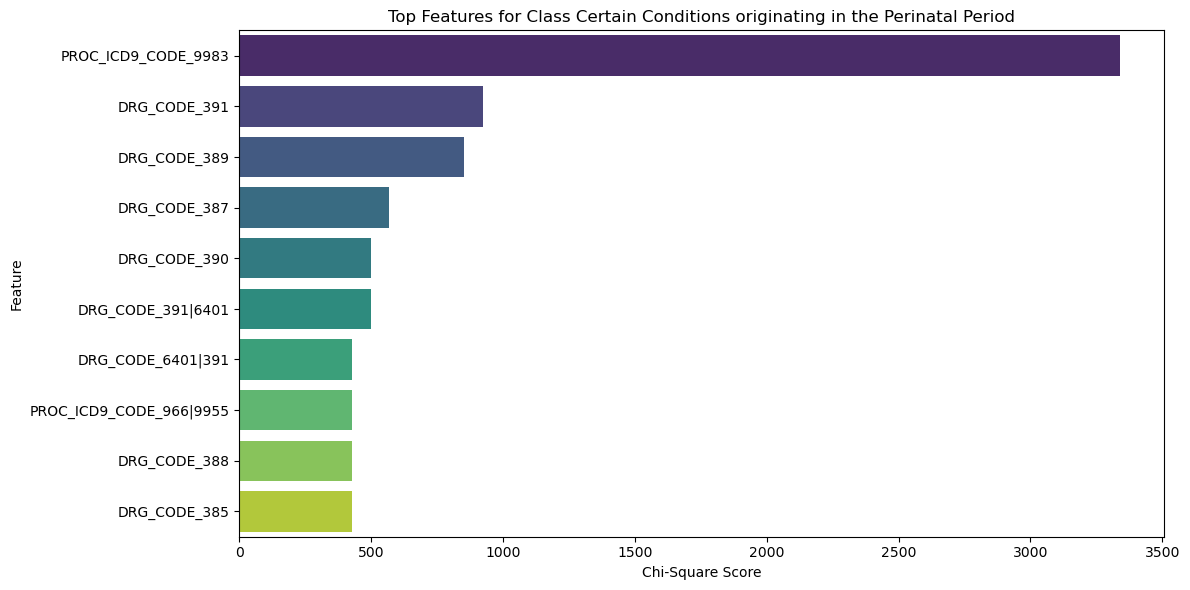

Performing Chi-Square Test for Class: Diseases of the Blood and Blood-forming Organs
Top Features for Class Diseases of the Blood and Blood-forming Organs:
                      Feature  Chi2 Score
7367            DRG_CODE_483   83.045584
5653     PROC_ICD9_CODE_9983   42.923221
7735  DRG_CODE_7204|7204|871   30.607144
5679            DRG_CODE_107   27.420010
7328            DRG_CODE_468   27.014637
6099            DRG_CODE_174   25.541476
7129            DRG_CODE_415   22.569838
170       PROC_ICD9_CODE_159   19.165310
7688  DRG_CODE_7104|7104|853   16.914970
6587  DRG_CODE_2413|2413|378   16.825593


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


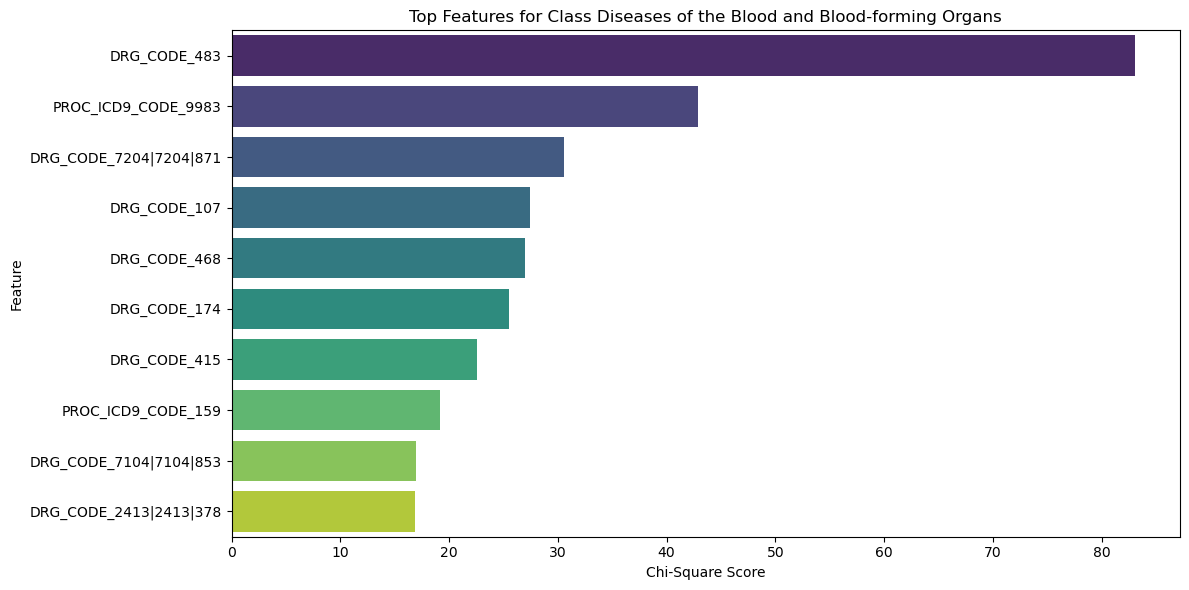

Performing Chi-Square Test for Class: Diseases of the Circulatory System
Top Features for Class Diseases of the Circulatory System:
                                                Feature  Chi2 Score
5653                               PROC_ICD9_CODE_9983  329.163194
7082                                      DRG_CODE_391   91.045139
7077                                      DRG_CODE_389   84.041667
7358                                      DRG_CODE_480   58.450112
7073                                      DRG_CODE_387   56.027778
7086                                 DRG_CODE_391|6401   49.024306
7079                                      DRG_CODE_390   49.024306
2577  PROC_ICD9_CODE_4319|966|8628|4525|9915|3893|4516   42.020833
7063                                      DRG_CODE_385   42.020833
4670                           PROC_ICD9_CODE_966|9955   42.020833


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


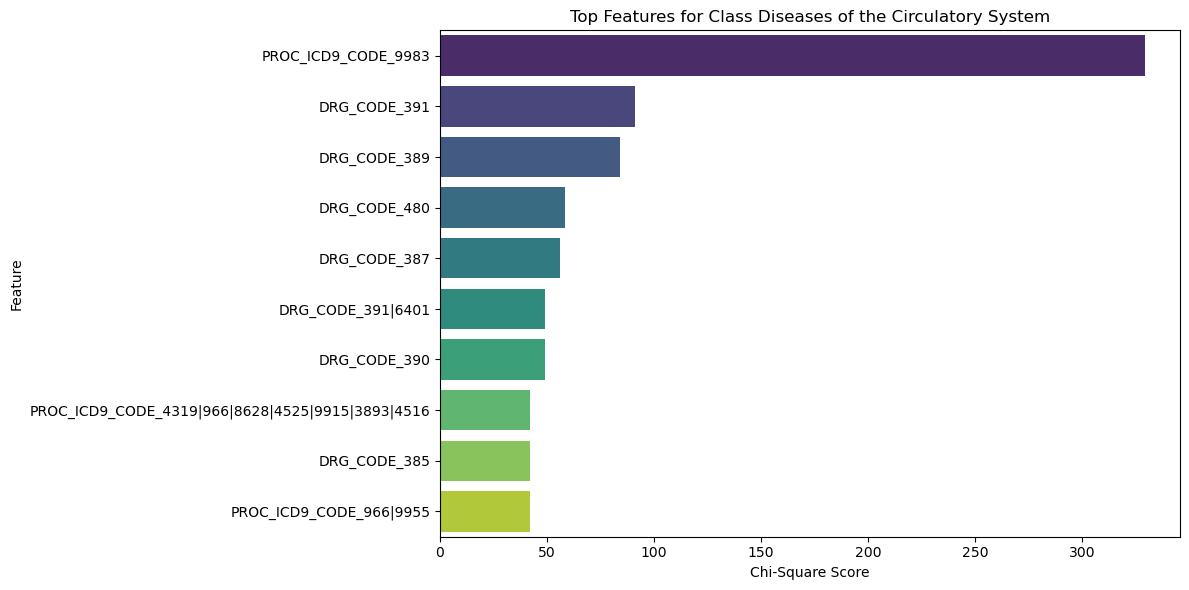

Performing Chi-Square Test for Class: Diseases of the Digestive System
Top Features for Class Diseases of the Digestive System:
                      Feature  Chi2 Score
6099            DRG_CODE_174   86.683623
7347            DRG_CODE_475   56.382624
2706     PROC_ICD9_CODE_4513   52.308138
5660              DRG_CODE_1   47.744470
5653     PROC_ICD9_CODE_9983   44.460532
5952            DRG_CODE_148   36.551706
6717  DRG_CODE_2533|2533|378   35.941990
7358            DRG_CODE_480   31.317639
7367            DRG_CODE_483   31.310158
5956        DRG_CODE_14|14|5   25.370817


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


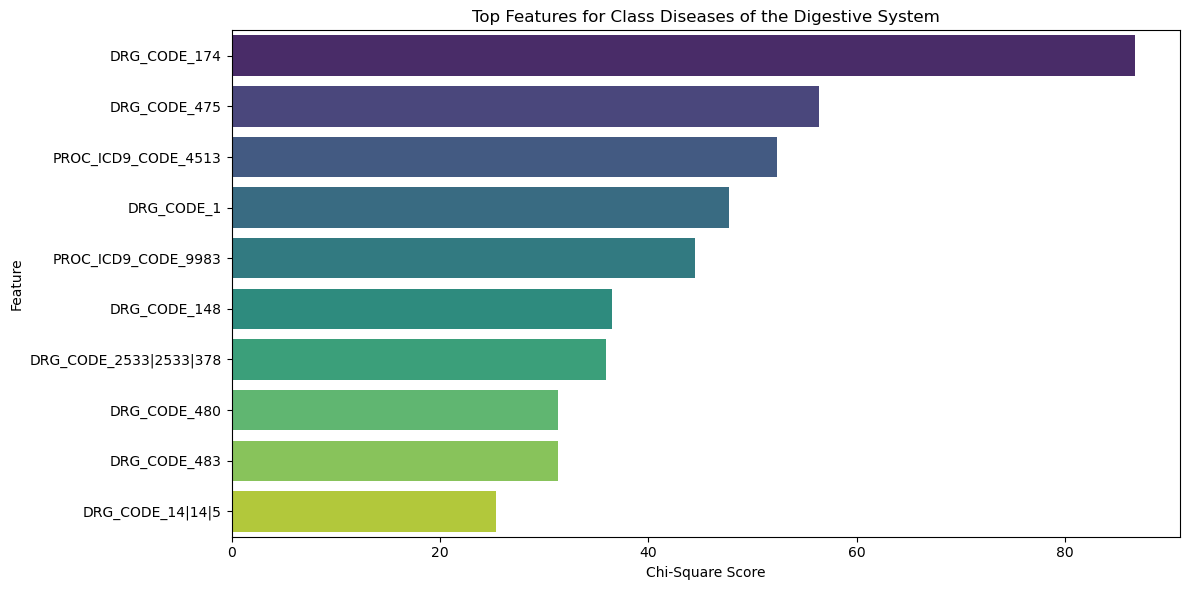

Performing Chi-Square Test for Class: Diseases of the Genitourinary System
Top Features for Class Diseases of the Genitourinary System:
                      Feature  Chi2 Score
2350     PROC_ICD9_CODE_3995  110.139622
7735  DRG_CODE_7204|7204|871   85.827825
5653     PROC_ICD9_CODE_9983   64.341213
7688  DRG_CODE_7104|7104|853   31.776227
5679            DRG_CODE_107   31.504235
1810     PROC_ICD9_CODE_3893   31.306381
6967            DRG_CODE_316   28.985926
49        PROC_ICD9_CODE_131   28.293761
5660              DRG_CODE_1   27.652270
7347            DRG_CODE_475   27.070655


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


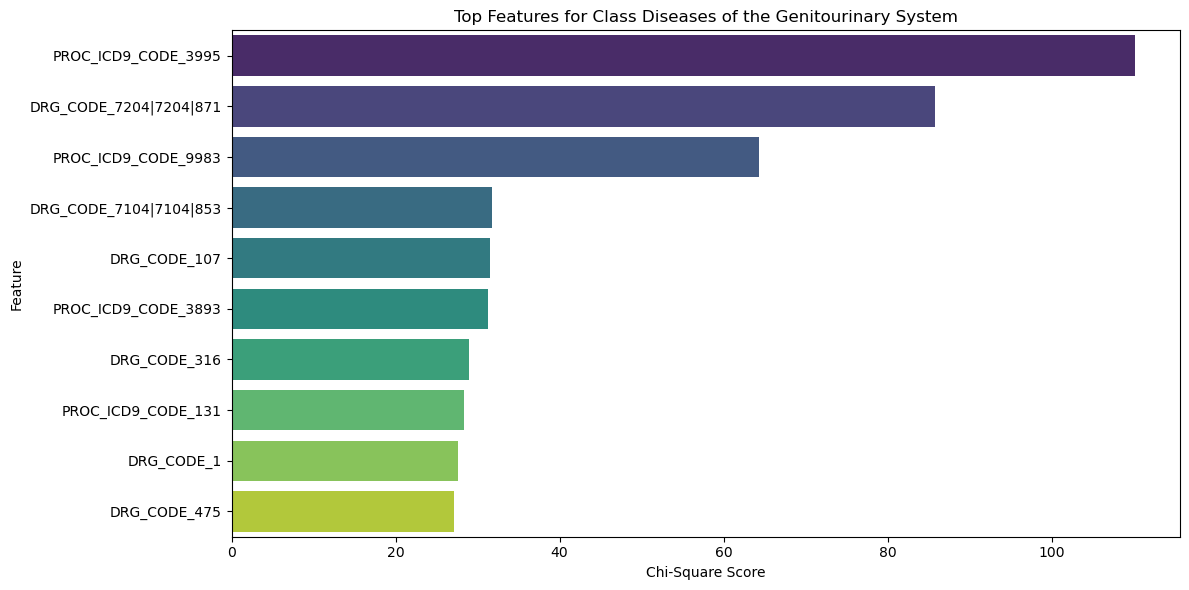

Performing Chi-Square Test for Class: Diseases of the Nervous System and Mental Disorders
Top Features for Class Diseases of the Nervous System and Mental Disorders:
                      Feature  Chi2 Score
5653     PROC_ICD9_CODE_9983   51.040724
7367            DRG_CODE_483   49.104227
7132            DRG_CODE_416   46.674791
5761            DRG_CODE_127   39.680779
7735  DRG_CODE_7204|7204|871   36.011329
4444     PROC_ICD9_CODE_9462   35.912500
6967            DRG_CODE_316   35.033095
5683            DRG_CODE_110   34.017346
5679            DRG_CODE_107   32.073450
7356            DRG_CODE_478   30.220499


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


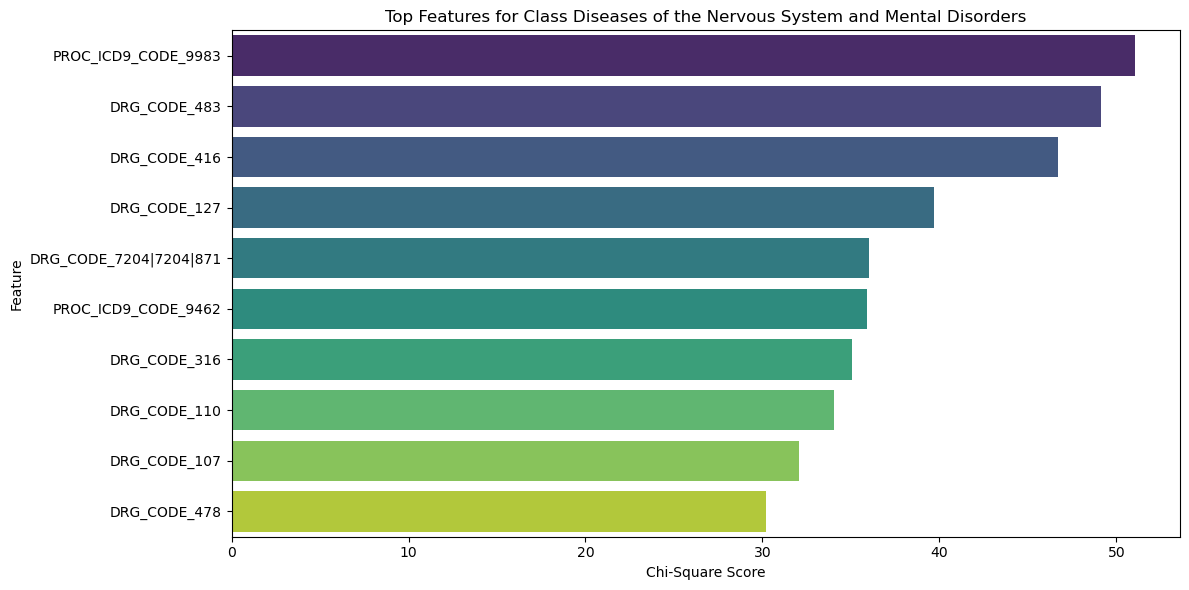

Performing Chi-Square Test for Class: Diseases of the Respiratory System
Top Features for Class Diseases of the Respiratory System:
                      Feature  Chi2 Score
7347            DRG_CODE_475  140.657690
7367            DRG_CODE_483  111.653139
5653     PROC_ICD9_CODE_9983   74.180089
2350     PROC_ICD9_CODE_3995   61.640324
5799  DRG_CODE_1334|1334|208   57.023388
4402     PROC_ICD9_CODE_9390   53.202617
7734  DRG_CODE_7204|7204|870   48.786676
4444     PROC_ICD9_CODE_9462   47.055868
7503        DRG_CODE_54|54|4   44.985117
5780  DRG_CODE_1304|1304|207   42.450744


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


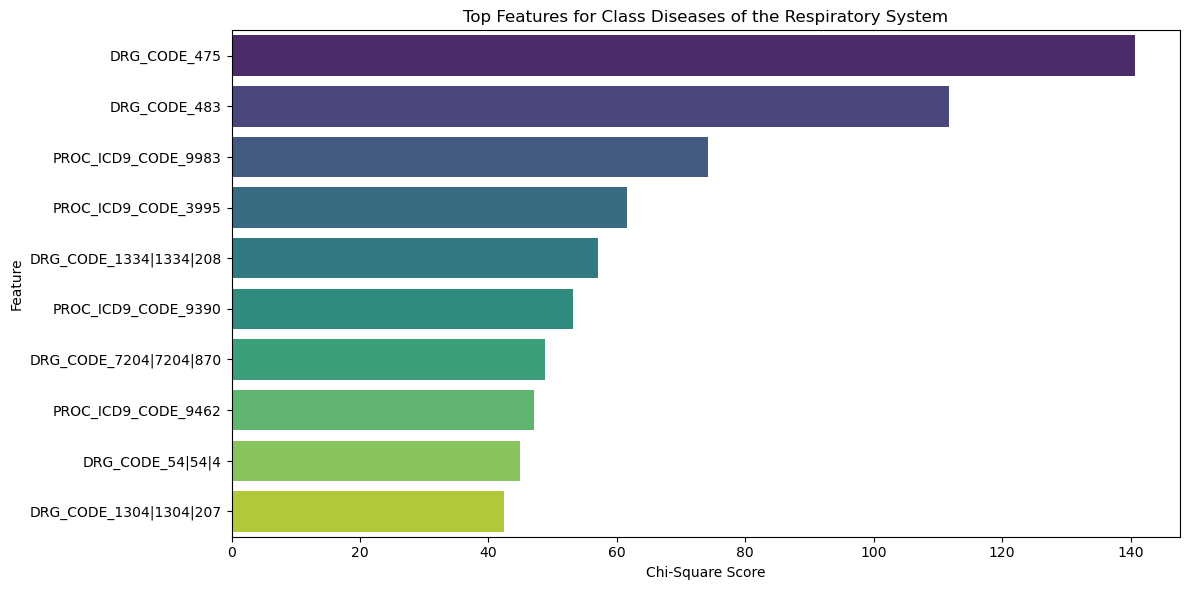

Performing Chi-Square Test for Class: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Top Features for Class Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases:
                       Feature  Chi2 Score
5653      PROC_ICD9_CODE_9983  143.135937
7367             DRG_CODE_483   63.256903
7082             DRG_CODE_391   49.688285
5660               DRG_CODE_1   34.859237
7073             DRG_CODE_387   30.577406
7086        DRG_CODE_391|6401   26.755230
5683             DRG_CODE_110   26.661640
1810      PROC_ICD9_CODE_3893   26.611321
7074             DRG_CODE_388   22.933054
4670  PROC_ICD9_CODE_966|9955   22.933054


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


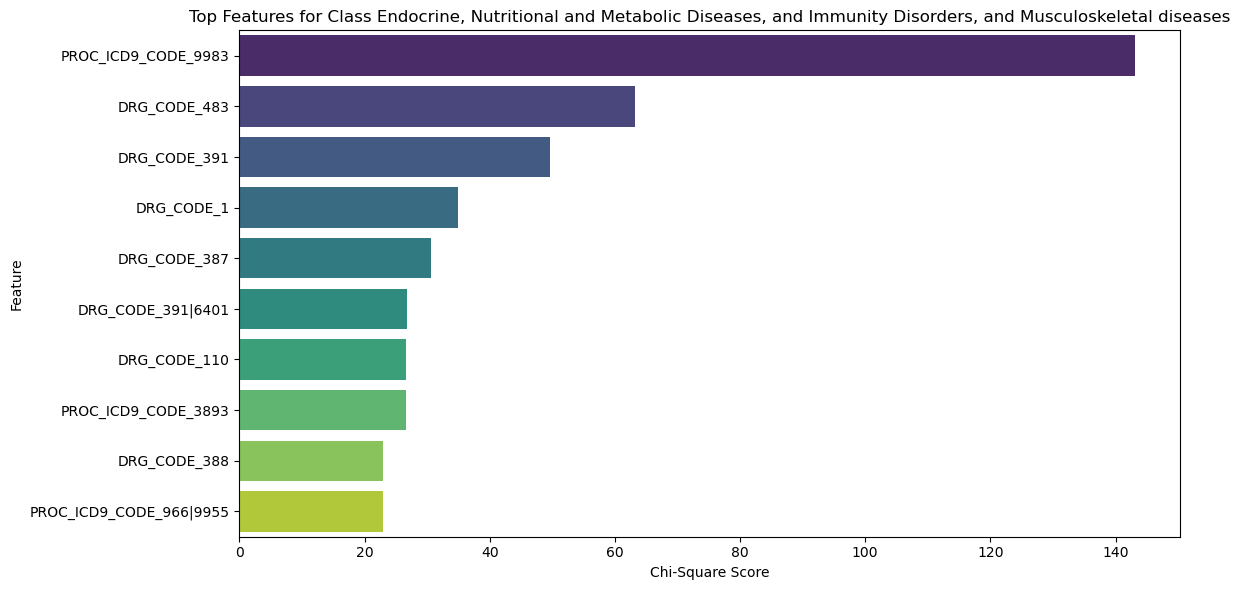

Performing Chi-Square Test for Class: Infectious and Parasitic Diseases
Top Features for Class Infectious and Parasitic Diseases:
                      Feature  Chi2 Score
7735  DRG_CODE_7204|7204|871  283.950311
7132            DRG_CODE_416  162.057858
7734  DRG_CODE_7204|7204|870   99.382609
7688  DRG_CODE_7104|7104|853   89.057143
7718  DRG_CODE_7203|7203|871   65.190814
7724       DRG_CODE_7204|416   56.790062
7727       DRG_CODE_7204|576   41.301863
6400  DRG_CODE_2064|7214|314   40.708703
5653     PROC_ICD9_CODE_9983   36.414822
7135       DRG_CODE_416|7204   36.139130


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


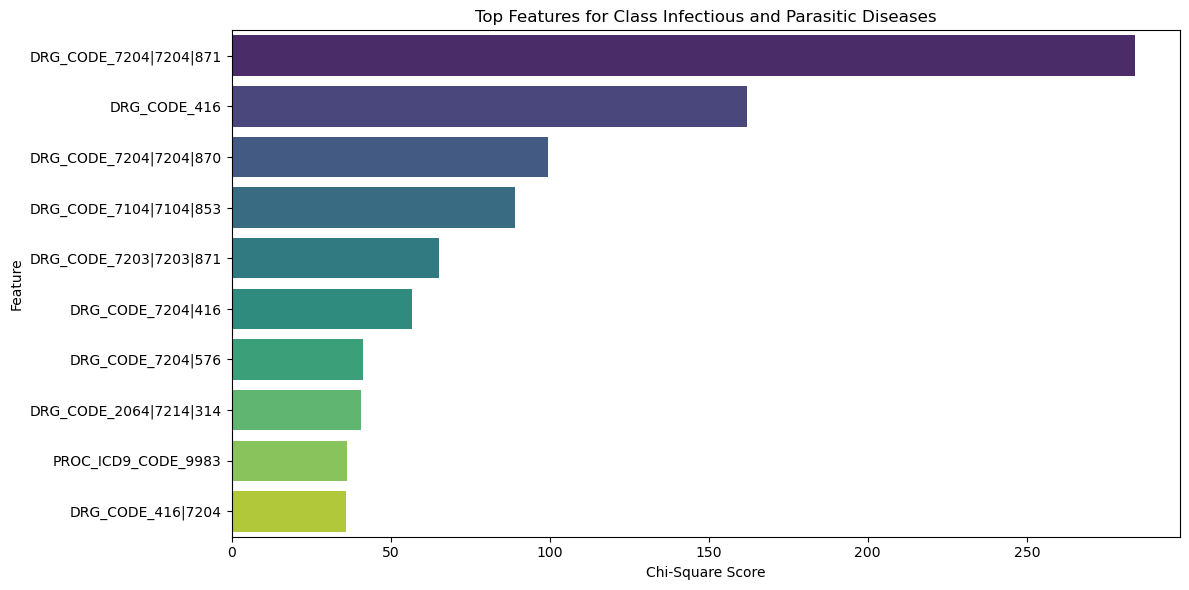

Performing Chi-Square Test for Class: Injury and Poisoning
Top Features for Class Injury and Poisoning:
                      Feature  Chi2 Score
7735  DRG_CODE_7204|7204|871  228.069911
7347            DRG_CODE_475   83.410749
7734  DRG_CODE_7204|7204|870   73.243609
2350     PROC_ICD9_CODE_3995   71.455224
6099            DRG_CODE_174   66.457931
7688  DRG_CODE_7104|7104|853   64.825454
4402     PROC_ICD9_CODE_9390   51.380801
7129            DRG_CODE_415   48.207817
7718  DRG_CODE_7203|7203|871   45.320738
7255        DRG_CODE_44|44|3   44.857496


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


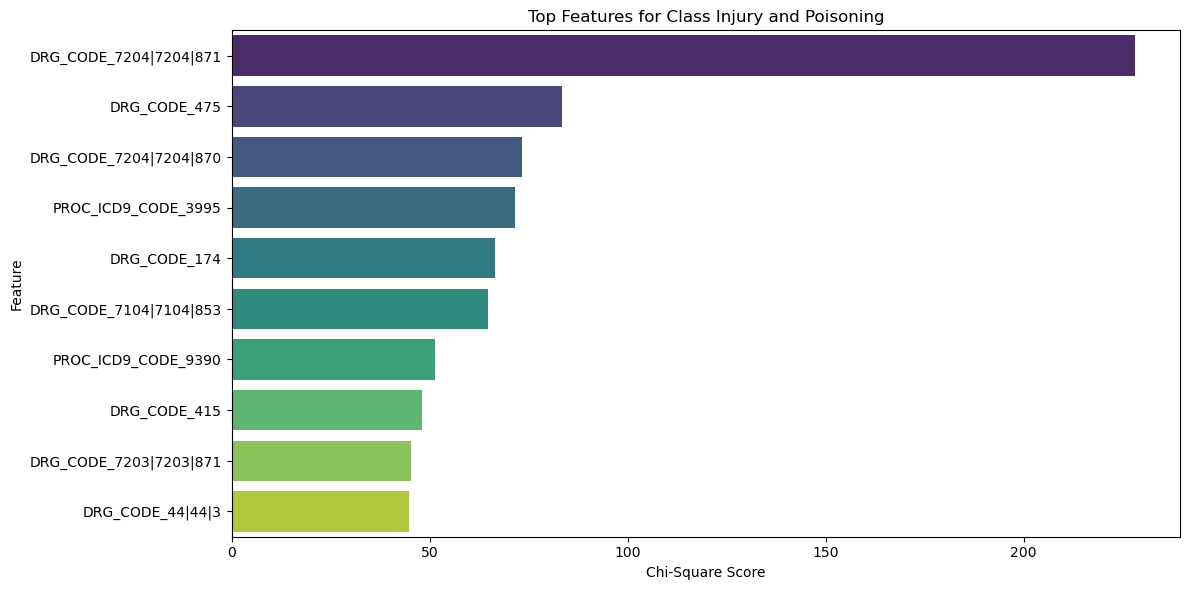

Performing Chi-Square Test for Class: Symptoms, Signs and Ill-defined Conditions
Top Features for Class Symptoms, Signs and Ill-defined Conditions:
                      Feature  Chi2 Score
7735  DRG_CODE_7204|7204|871  129.805168
7734  DRG_CODE_7204|7204|870   48.247214
5679            DRG_CODE_107   42.764726
5653     PROC_ICD9_CODE_9983   40.437450
7688  DRG_CODE_7104|7104|853   36.698119
6099            DRG_CODE_174   30.471396
7356            DRG_CODE_478   28.523962
7347            DRG_CODE_475   24.364530
7255        DRG_CODE_44|44|3   24.050277
7503        DRG_CODE_54|54|4   14.803879


C:\Users\SnehalChoudhari-I\AppData\Local\Temp\ipykernel_48920\2749203863.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')


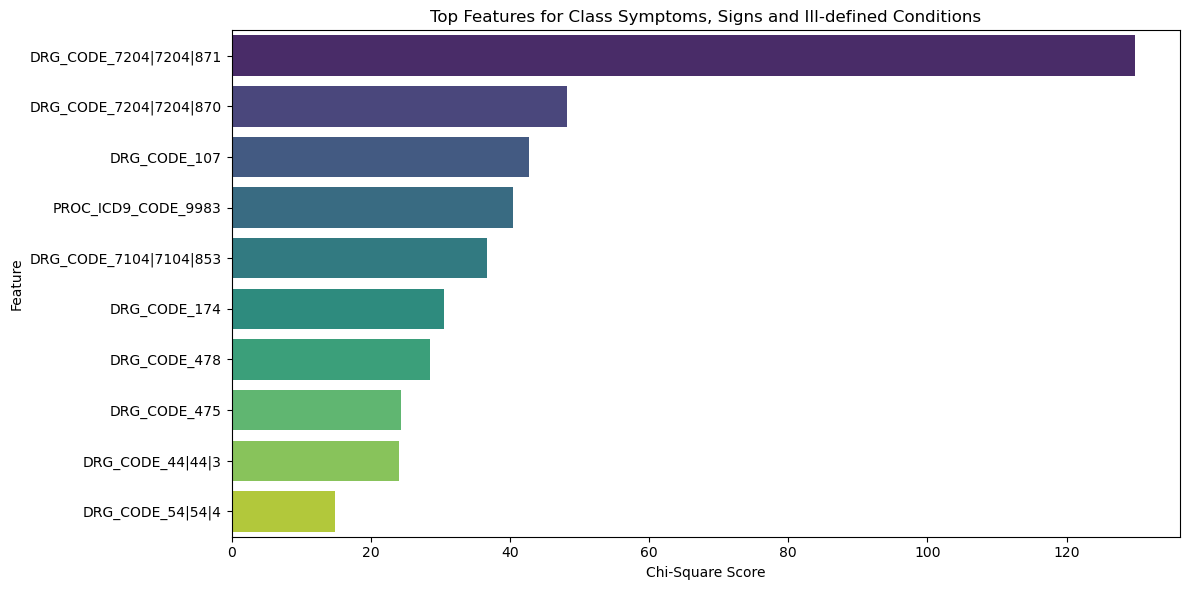

In [92]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `combined_df` is already loaded
X = combined_df_copy.drop(columns=['label_list'])  # Features
y = combined_df_copy['label_list']                 # Multi-class target

# Step 1: Transform `label_list` to Binary Format
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)

# Step 2: Scale Numerical Variables
numerical_features = X.select_dtypes(include=['float', 'int']).columns
scaler = MinMaxScaler()
X_scaled_num = scaler.fit_transform(X[numerical_features])

# Step 3: Encode Categorical Variables Using Sparse Representation
cat_features = X.select_dtypes(include=['object', 'category']).columns
onehot_encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_encoded_cat = onehot_encoder.fit_transform(X[cat_features])

# Step 4: Combine Scaled Numerical and Encoded Categorical Features
X_combined = hstack([csr_matrix(X_scaled_num), X_encoded_cat])

# Step 5: Perform Chi-Square Test for Each Label
for i, class_label in enumerate(mlb.classes_):
    print(f"Performing Chi-Square Test for Class: {class_label}")
    chi2_selector = SelectKBest(chi2, k='all')
    chi2_selector.fit(X_combined, y_binary[:, i])

    # Retrieve Chi-Square Scores
    feature_names = list(numerical_features) + list(onehot_encoder.get_feature_names_out(cat_features))
    chi2_scores = pd.DataFrame({
        'Feature': feature_names,
        'Chi2 Score': chi2_selector.scores_
    }).sort_values(by='Chi2 Score', ascending=False)

    # Display Top Features
    print(f"Top Features for Class {class_label}:\n", chi2_scores.head(10))

    # Visualize Top Features
    top_features = chi2_scores.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_features, x='Chi2 Score', y='Feature', palette='viridis')
    plt.title(f'Top Features for Class {class_label}')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [93]:
combined_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9220 entries, 0 to 9219
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   LEN_OF_STAY                       9220 non-null   int64 
 1   GENDER                            9220 non-null   object
 2   AGE                               9220 non-null   int32 
 3   PROC_ICD9_CODE                    9220 non-null   object
 4   DRG_CODE                          9220 non-null   object
 5   cleaned_text                      9220 non-null   object
 6   Past_6_Months_Hospital_Admission  9220 non-null   int64 
 7   label_list                        9220 non-null   object
dtypes: int32(1), int64(2), object(5)
memory usage: 540.4+ KB


# Approach 1- Apply Unified features, not effective on minority classes, hence proceed with 2nd approach

In [222]:
# Aggregate top features across all labels
top_features_all_labels = set()  # Use a set to avoid duplicates
for class_label in mlb.classes_:
    # Get the top 10 features for the current label
    top_features = chi2_scores.head(20)['Feature'].tolist()
    top_features_all_labels.update(top_features)

# Convert to list
top_features_all_labels = list(top_features_all_labels)
print(f"Unified feature set: {top_features_all_labels}")


Unified feature set: ['DRG_CODE_1', 'DRG_CODE_416|7204', 'LEN_OF_STAY', 'DRG_CODE_54|542', 'DRG_CODE_54|54|4', 'PROC_ICD9_CODE_9983', 'DRG_CODE_7104|7104|853', 'DRG_CODE_174', 'DRG_CODE_478', 'DRG_CODE_109', 'DRG_CODE_514', 'DRG_CODE_391', 'DRG_CODE_107', 'DRG_CODE_7204|7204|870', 'DRG_CODE_121', 'DRG_CODE_1374|1374|208', 'DRG_CODE_7204|7204|871', 'DRG_CODE_475', 'DRG_CODE_516', 'DRG_CODE_44|44|3']


In [223]:
# Filter the feature matrix based on the unified feature set
feature_indices = [feature_names.index(f) for f in top_features_all_labels]
X_filtered = X_combined[:, feature_indices]


In [224]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

model = OneVsRestClassifier(LogisticRegression())
model.fit(X_filtered, y_binary)


OneVsRestClassifier(estimator=LogisticRegression())

In [225]:
for i, class_label in enumerate(mlb.classes_):
    print(f"Training model for {class_label}")
    top_features = chi2_scores.head(10)['Feature'].tolist()
    feature_indices = [feature_names.index(f) for f in top_features]
    X_label_specific = X_combined[:, feature_indices]

    model = LogisticRegression()
    model.fit(X_label_specific, y_binary[:, i])


Training model for Certain Conditions originating in the Perinatal Period
Training model for Diseases of the Blood and Blood-forming Organs
Training model for Diseases of the Circulatory System
Training model for Diseases of the Digestive System
Training model for Diseases of the Genitourinary System
Training model for Diseases of the Nervous System and Mental Disorders
Training model for Diseases of the Respiratory System
Training model for Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training model for Infectious and Parasitic Diseases
Training model for Injury and Poisoning
Training model for Symptoms, Signs and Ill-defined Conditions


In [226]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_binary, test_size=0.3, random_state=42)

# Initialize the multi-label classifier
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))  # Use any base classifier

# Train the model
model.fit(X_train, y_train)

# Predict on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate on training set
print("=== Training Set Evaluation ===")
print(classification_report(y_train, y_train_pred, target_names=mlb.classes_))
print(f"Hamming Loss (Train): {hamming_loss(y_train, y_train_pred)}")
print(f"Accuracy (Train): {accuracy_score(y_train, y_train_pred)}")

# Evaluate on testing set
print("\n=== Testing Set Evaluation ===")
print(classification_report(y_test, y_test_pred, target_names=mlb.classes_))
print(f"Hamming Loss (Test): {hamming_loss(y_test, y_test_pred)}")
print(f"Accuracy (Test): {accuracy_score(y_test, y_test_pred)}")


=== Training Set Evaluation ===
                                                                                                     precision    recall  f1-score   support

                                             Certain Conditions originating in the Perinatal Period       1.00      0.37      0.54        99
                                                     Diseases of the Blood and Blood-forming Organs       0.57      0.19      0.28      3096
                                                                 Diseases of the Circulatory System       0.88      1.00      0.93      5629
                                                                   Diseases of the Digestive System       0.58      0.36      0.44      3157
                                                               Diseases of the Genitourinary System       0.59      0.97      0.74      3701
                                                Diseases of the Nervous System and Mental Disorders       0.55      0.90 

# Approach 2- Label Specific Feature usage modelling

In [94]:
# Example of storing top features for each label
label_specific_features = {}
for i, class_label in enumerate(mlb.classes_):
    top_features = chi2_scores.head(20)['Feature'].tolist()  # Adjust number of top features
    label_specific_features[class_label] = top_features


In [95]:
label_matrices = {}
for i, class_label in enumerate(mlb.classes_):
    top_features = label_specific_features[class_label]
    feature_indices = [feature_names.index(f) for f in top_features]
    label_matrices[class_label] = X_combined[:, feature_indices]  # Subset of features


In [96]:
from sklearn.linear_model import LogisticRegression

label_classifiers = {}
for i, class_label in enumerate(mlb.classes_):
    print(f"Training model for {class_label}")
    X_label = label_matrices[class_label]
    y_label = y_binary[:, i]  # Binary target for the label
    
    # Train a logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_label, y_label)
    label_classifiers[class_label] = model


Training model for Certain Conditions originating in the Perinatal Period
Training model for Diseases of the Blood and Blood-forming Organs
Training model for Diseases of the Circulatory System
Training model for Diseases of the Digestive System
Training model for Diseases of the Genitourinary System
Training model for Diseases of the Nervous System and Mental Disorders
Training model for Diseases of the Respiratory System
Training model for Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training model for Infectious and Parasitic Diseases
Training model for Injury and Poisoning
Training model for Symptoms, Signs and Ill-defined Conditions


In [97]:
y_pred_label_specific = np.zeros_like(y_binary)
for i, class_label in enumerate(mlb.classes_):
    X_label = label_matrices[class_label]
    model = label_classifiers[class_label]
    y_pred_label_specific[:, i] = model.predict(X_label)


# Logistic Regression

In [98]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Perform Feature Selection for Each Label
label_specific_features = {
    class_label: chi2_scores.head(20)['Feature'].tolist()  # Use all features from chi-square results
    for class_label in mlb.classes_
}

# Step 3: Create Label-Specific Feature Matrices
def create_label_matrices(X, label_specific_features, feature_names):
    return {
        class_label: X[:, [feature_names.index(f) for f in label_specific_features[class_label]]]
        for class_label in mlb.classes_
    }

label_matrices_train = create_label_matrices(X_train, label_specific_features, feature_names)
label_matrices_test = create_label_matrices(X_test, label_specific_features, feature_names)

# Step 4: Train Logistic Regression for Each Label
def train_logistic_regression(label_matrices_train, y_train):
    classifiers = {}
    for i, class_label in enumerate(mlb.classes_):
        print(f"Training LogisticRegression for class: {class_label}")
        X_train_label = label_matrices_train[class_label]
        y_train_label = y_train[:, i]  # Binary target for the label
        
        # Define and train the Logistic Regression model
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train_label, y_train_label)
        classifiers[class_label] = model
    return classifiers

# Train Logistic Regression Models
print("\n=== Training Logistic Regression ===")
lr_classifiers = train_logistic_regression(label_matrices_train, y_train)

# Step 5: Make Predictions for Training and Testing Sets
def make_predictions(classifiers, label_matrices, num_samples, num_labels):
    y_pred = np.zeros((num_samples, num_labels))
    for i, class_label in enumerate(mlb.classes_):
        y_pred[:, i] = classifiers[class_label].predict(label_matrices[class_label])
    return y_pred

# Predict on Training and Testing Sets
y_train_pred_lr = make_predictions(lr_classifiers, label_matrices_train, X_train.shape[0], y_train.shape[1])
y_test_pred_lr = make_predictions(lr_classifiers, label_matrices_test, X_test.shape[0], y_test.shape[1])

# Step 6: Evaluate the Model
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate Logistic Regression
print("\nLogistic Regression - Training Performance")
evaluate_performance(y_train, y_train_pred_lr, "Training")

print("\nLogistic Regression - Testing Performance")
evaluate_performance(y_test, y_test_pred_lr, "Testing")



=== Training Logistic Regression ===
Training LogisticRegression for class: Certain Conditions originating in the Perinatal Period
Training LogisticRegression for class: Diseases of the Blood and Blood-forming Organs
Training LogisticRegression for class: Diseases of the Circulatory System
Training LogisticRegression for class: Diseases of the Digestive System
Training LogisticRegression for class: Diseases of the Genitourinary System
Training LogisticRegression for class: Diseases of the Nervous System and Mental Disorders
Training LogisticRegression for class: Diseases of the Respiratory System
Training LogisticRegression for class: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training LogisticRegression for class: Infectious and Parasitic Diseases
Training LogisticRegression for class: Injury and Poisoning
Training LogisticRegression for class: Symptoms, Signs and Ill-defined Conditions

Logistic Regression - Training Performan

C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Binary Relevance in Logistic Regsression

In [105]:
#pip install scikit-multilearn

In [106]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

# Initialize Binary Relevance with a base classifier
br_classifier = BinaryRelevance(classifier=LogisticRegression(max_iter=1000), require_dense=[False, True])

# Train the model
br_classifier.fit(X_train, y_train)

# Predict on training and testing sets
y_pred_train_br = br_classifier.predict(X_train)
y_pred_test_br = br_classifier.predict(X_test)

# Evaluate on Training Set
print("\n=== Training Set Performance ===")
print("Hamming Loss (Training):", hamming_loss(y_train, y_pred_train_br.toarray()))
print("Accuracy (Training):", accuracy_score(y_train, y_pred_train_br.toarray()))
print("\nClassification Report (Training):")
print(classification_report(y_train, y_pred_train_br.toarray(), target_names=mlb.classes_))

# Evaluate on Testing Set
print("\n=== Testing Set Performance ===")
print("Hamming Loss (Testing):", hamming_loss(y_test, y_pred_test_br.toarray()))
print("Accuracy (Testing):", accuracy_score(y_test, y_pred_test_br.toarray()))
print("\nClassification Report (Testing):")
print(classification_report(y_test, y_pred_test_br.toarray(), target_names=mlb.classes_))



=== Training Set Performance ===
Hamming Loss (Training): 0.04000338056737189
Accuracy (Training): 0.6746203904555315

Classification Report (Training):
                                                                                                     precision    recall  f1-score   support

                                             Certain Conditions originating in the Perinatal Period       1.00      0.53      0.69        99
                                                     Diseases of the Blood and Blood-forming Organs       0.98      0.96      0.97      3096
                                                                 Diseases of the Circulatory System       0.92      1.00      0.96      5629
                                                                   Diseases of the Digestive System       0.99      0.95      0.97      3157
                                                               Diseases of the Genitourinary System       0.96      0.98      0.97      3701

C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ClassifierChain on logistic regression

In [107]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

# Initialize Classifier Chains with a base classifier
cc_classifier = ClassifierChain(classifier=LogisticRegression(max_iter=1000), require_dense=[False, True])

# Train the model
cc_classifier.fit(X_train, y_train)

# Predict on training and testing sets
y_pred_train_cc = cc_classifier.predict(X_train)
y_pred_test_cc = cc_classifier.predict(X_test)

# Evaluate on Training Set
print("\n=== Training Set Performance ===")
print("Hamming Loss (Training):", hamming_loss(y_train, y_pred_train_cc.toarray()))
print("Accuracy (Training):", accuracy_score(y_train, y_pred_train_cc.toarray()))
print("\nClassification Report (Training):")
print(classification_report(y_train, y_pred_train_cc.toarray(), target_names=mlb.classes_))

# Evaluate on Testing Set
print("\n=== Testing Set Performance ===")
print("Hamming Loss (Testing):", hamming_loss(y_test, y_pred_test_cc.toarray()))
print("Accuracy (Testing):", accuracy_score(y_test, y_pred_test_cc.toarray()))
print("\nClassification Report (Testing):")
print(classification_report(y_test, y_pred_test_cc.toarray(), target_names=mlb.classes_))



=== Training Set Performance ===
Hamming Loss (Training): 0.05100431022339916
Accuracy (Training): 0.6399132321041214

Classification Report (Training):
                                                                                                     precision    recall  f1-score   support

                                             Certain Conditions originating in the Perinatal Period       1.00      0.53      0.69        99
                                                     Diseases of the Blood and Blood-forming Organs       0.97      0.96      0.96      3096
                                                                 Diseases of the Circulatory System       0.91      1.00      0.95      5629
                                                                   Diseases of the Digestive System       0.97      0.94      0.96      3157
                                                               Diseases of the Genitourinary System       0.93      0.98      0.95      3701

# Decision Tree classifier

In [108]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Perform Feature Selection for Each Label
label_specific_features = {
    class_label: chi2_scores.head(20)['Feature'].tolist()  # Use top 500 features
    for class_label in mlb.classes_
}

# Step 3: Create Label-Specific Feature Matrices
def create_label_matrices(X, label_specific_features, feature_names):
    return {
        class_label: X[:, [feature_names.index(f) for f in label_specific_features[class_label]]]
        for class_label in mlb.classes_
    }

label_matrices_train = create_label_matrices(X_train, label_specific_features, feature_names)
label_matrices_test = create_label_matrices(X_test, label_specific_features, feature_names)

# Step 4: Train Decision Tree Models for Each Label
def train_decision_tree(label_matrices_train, y_train):
    classifiers = {}
    for i, class_label in enumerate(mlb.classes_):
        print(f"Training DecisionTreeClassifier for class: {class_label}")
        X_train_label = label_matrices_train[class_label]
        y_train_label = y_train[:, i]  # Binary target for the label

        # Define and train the Decision Tree model
        model = DecisionTreeClassifier(random_state=42, max_depth=10)  # You can adjust max_depth for tuning
        model.fit(X_train_label, y_train_label)
        classifiers[class_label] = model
    return classifiers

# Train the Decision Tree Classifiers
print("\n=== Training Decision Tree Classifiers ===")
dt_classifiers = train_decision_tree(label_matrices_train, y_train)

# Step 5: Make Predictions for Training and Testing Sets
def make_predictions(classifiers, label_matrices, num_samples, num_labels):
    y_pred = np.zeros((num_samples, num_labels))
    for i, class_label in enumerate(classifiers.keys()):
        y_pred[:, i] = classifiers[class_label].predict(label_matrices[class_label])
    return y_pred

# Predict on Training and Testing Sets
y_train_pred_dt = make_predictions(dt_classifiers, label_matrices_train, X_train.shape[0], y_train.shape[1])
y_test_pred_dt = make_predictions(dt_classifiers, label_matrices_test, X_test.shape[0], y_test.shape[1])

# Step 6: Evaluate the Model
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate on Training and Testing Sets
print("\nDecision Tree - Training Performance")
evaluate_performance(y_train, y_train_pred_dt, "Training")

print("\nDecision Tree - Testing Performance")
evaluate_performance(y_test, y_test_pred_dt, "Testing")



=== Training Decision Tree Classifiers ===
Training DecisionTreeClassifier for class: Certain Conditions originating in the Perinatal Period
Training DecisionTreeClassifier for class: Diseases of the Blood and Blood-forming Organs
Training DecisionTreeClassifier for class: Diseases of the Circulatory System
Training DecisionTreeClassifier for class: Diseases of the Digestive System
Training DecisionTreeClassifier for class: Diseases of the Genitourinary System
Training DecisionTreeClassifier for class: Diseases of the Nervous System and Mental Disorders
Training DecisionTreeClassifier for class: Diseases of the Respiratory System
Training DecisionTreeClassifier for class: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training DecisionTreeClassifier for class: Infectious and Parasitic Diseases
Training DecisionTreeClassifier for class: Injury and Poisoning
Training DecisionTreeClassifier for class: Symptoms, Signs and Ill-defined Co

# KNN Classifier

In [109]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Perform Feature Selection for Each Label
label_specific_features = {
    class_label: chi2_scores.head(20)['Feature'].tolist()  # Use top 500 features
    for class_label in mlb.classes_
}

# Step 3: Create Label-Specific Feature Matrices
def create_label_matrices(X, label_specific_features, feature_names):
    return {
        class_label: X[:, [feature_names.index(f) for f in label_specific_features[class_label]]]
        for class_label in mlb.classes_
    }

label_matrices_train = create_label_matrices(X_train, label_specific_features, feature_names)
label_matrices_test = create_label_matrices(X_test, label_specific_features, feature_names)

# Step 4: Train KNN Models for Each Label
def train_knn(label_matrices_train, y_train, n_neighbors=5):
    classifiers = {}
    for i, class_label in enumerate(mlb.classes_):
        print(f"Training KNeighborsClassifier for class: {class_label}")
        X_train_label = label_matrices_train[class_label]
        y_train_label = y_train[:, i]  # Binary target for the label

        # Define and train the KNN model
        model = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)  # Adjust n_neighbors for tuning
        model.fit(X_train_label, y_train_label)
        classifiers[class_label] = model
    return classifiers

# Train the KNN Classifiers
print("\n=== Training KNN Classifiers ===")
knn_classifiers = train_knn(label_matrices_train, y_train, n_neighbors=5)

# Step 5: Make Predictions for Training and Testing Sets
def make_predictions(classifiers, label_matrices, num_samples, num_labels):
    y_pred = np.zeros((num_samples, num_labels))
    for i, class_label in enumerate(classifiers.keys()):
        y_pred[:, i] = classifiers[class_label].predict(label_matrices[class_label])
    return y_pred

# Predict on Training and Testing Sets
y_train_pred_knn = make_predictions(knn_classifiers, label_matrices_train, X_train.shape[0], y_train.shape[1])
y_test_pred_knn = make_predictions(knn_classifiers, label_matrices_test, X_test.shape[0], y_test.shape[1])

# Step 6: Evaluate the Model
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate on Training and Testing Sets
print("\nKNN - Training Performance")
evaluate_performance(y_train, y_train_pred_knn, "Training")

print("\nKNN - Testing Performance")
evaluate_performance(y_test, y_test_pred_knn, "Testing")



=== Training KNN Classifiers ===
Training KNeighborsClassifier for class: Certain Conditions originating in the Perinatal Period
Training KNeighborsClassifier for class: Diseases of the Blood and Blood-forming Organs
Training KNeighborsClassifier for class: Diseases of the Circulatory System
Training KNeighborsClassifier for class: Diseases of the Digestive System
Training KNeighborsClassifier for class: Diseases of the Genitourinary System
Training KNeighborsClassifier for class: Diseases of the Nervous System and Mental Disorders
Training KNeighborsClassifier for class: Diseases of the Respiratory System
Training KNeighborsClassifier for class: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training KNeighborsClassifier for class: Infectious and Parasitic Diseases
Training KNeighborsClassifier for class: Injury and Poisoning
Training KNeighborsClassifier for class: Symptoms, Signs and Ill-defined Conditions

KNN - Training Perform

# Random forest classifier

In [110]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Perform Feature Selection for Each Label
label_specific_features = {
    class_label: chi2_scores.head(20)['Feature'].tolist()  # Use all features from chi-square results
    for class_label in mlb.classes_
}

# Step 3: Create Label-Specific Feature Matrices
def create_label_matrices(X, label_specific_features, feature_names):
    return {
        class_label: X[:, [feature_names.index(f) for f in label_specific_features[class_label]]]
        for class_label in mlb.classes_
    }

label_matrices_train = create_label_matrices(X_train, label_specific_features, feature_names)
label_matrices_test = create_label_matrices(X_test, label_specific_features, feature_names)

# Step 4: Train Random Forest Classifier for Each Label
def train_random_forest(label_matrices_train, y_train):
    classifiers = {}
    for i, class_label in enumerate(mlb.classes_):
        print(f"Training RandomForestClassifier for class: {class_label}")
        X_train_label = label_matrices_train[class_label]
        y_train_label = y_train[:, i]  # Binary target for the label

        # Define and train the Random Forest model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_label, y_train_label)
        classifiers[class_label] = model
    return classifiers

# Train the Random Forest Classifiers
print("\n=== Training Random Forest Classifier ===")
rf_classifiers = train_random_forest(label_matrices_train, y_train)

# Step 5: Make Predictions for Training and Testing Sets
def make_predictions(classifiers, label_matrices, num_samples, num_labels):
    y_pred = np.zeros((num_samples, num_labels))
    for i, class_label in enumerate(mlb.classes_):
        y_pred[:, i] = classifiers[class_label].predict(label_matrices[class_label])
    return y_pred

# Predict on Training and Testing Sets
y_train_pred_rf = make_predictions(rf_classifiers, label_matrices_train, X_train.shape[0], y_train.shape[1])
y_test_pred_rf = make_predictions(rf_classifiers, label_matrices_test, X_test.shape[0], y_test.shape[1])

# Step 6: Evaluate the Model
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate on Training and Testing Sets
print("\nRandom Forest - Training Performance")
evaluate_performance(y_train, y_train_pred_rf, "Training")

print("\nRandom Forest - Testing Performance")
evaluate_performance(y_test, y_test_pred_rf, "Testing")


=== Training Random Forest Classifier ===
Training RandomForestClassifier for class: Certain Conditions originating in the Perinatal Period
Training RandomForestClassifier for class: Diseases of the Blood and Blood-forming Organs
Training RandomForestClassifier for class: Diseases of the Circulatory System
Training RandomForestClassifier for class: Diseases of the Digestive System
Training RandomForestClassifier for class: Diseases of the Genitourinary System
Training RandomForestClassifier for class: Diseases of the Nervous System and Mental Disorders
Training RandomForestClassifier for class: Diseases of the Respiratory System
Training RandomForestClassifier for class: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training RandomForestClassifier for class: Infectious and Parasitic Diseases
Training RandomForestClassifier for class: Injury and Poisoning
Training RandomForestClassifier for class: Symptoms, Signs and Ill-defined Con

In [111]:
# Classifier chain with random forest

In [112]:
import numpy as np
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Initialize and Train Classifier Chains
# Use RandomForestClassifier as the base model for Classifier Chains
cc_classifier = ClassifierChain(base_estimator=RandomForestClassifier(n_estimators=100, random_state=42))

print("Training Classifier Chains with Random Forest...")
cc_classifier.fit(X_train, y_train)

# Step 3: Make Predictions
y_train_pred = cc_classifier.predict(X_train)
y_test_pred = cc_classifier.predict(X_test)

# Step 4: Evaluate Performance
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate on Training and Testing Sets
print("\nClassifier Chains with Random Forest - Training Performance")
evaluate_performance(y_train, y_train_pred, "Training")

print("\nClassifier Chains with Random Forest - Testing Performance")
evaluate_performance(y_test, y_test_pred, "Testing")


Training Classifier Chains with Random Forest...

Classifier Chains with Random Forest - Training Performance
=== Training Set Evaluation ===
                                                                                                     precision    recall  f1-score   support

                                             Certain Conditions originating in the Perinatal Period       1.00      1.00      1.00        99
                                                     Diseases of the Blood and Blood-forming Organs       1.00      1.00      1.00      3096
                                                                 Diseases of the Circulatory System       1.00      1.00      1.00      5629
                                                                   Diseases of the Digestive System       1.00      1.00      1.00      3157
                                                               Diseases of the Genitourinary System       1.00      1.00      1.00      3701
           

In [113]:
# Gradient Boosting

In [114]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Train Gradient Boosting Classifier for Each Label
def train_gradient_boosting(label_matrices_train, y_train):
    classifiers = {}
    for i, class_label in enumerate(mlb.classes_):
        print(f"Training GradientBoostingClassifier for class: {class_label}")
        X_train_label = label_matrices_train[class_label]
        y_train_label = y_train[:, i]  # Binary target for the label

        # Define and train the Gradient Boosting model
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        model.fit(X_train_label, y_train_label)
        classifiers[class_label] = model
    return classifiers

# Step 3: Create Label-Specific Feature Matrices
def create_label_matrices(X, label_specific_features, feature_names):
    return {
        class_label: X[:, [feature_names.index(f) for f in label_specific_features[class_label]]]
        for class_label in mlb.classes_
}

# Assuming `label_specific_features` and `feature_names` are predefined
label_matrices_train = create_label_matrices(X_train, label_specific_features, feature_names)
label_matrices_test = create_label_matrices(X_test, label_specific_features, feature_names)

# Train Gradient Boosting Classifiers
print("\n=== Training Gradient Boosting Classifier ===")
gb_classifiers = train_gradient_boosting(label_matrices_train, y_train)

# Step 4: Make Predictions for Training and Testing Sets
def make_predictions(classifiers, label_matrices, num_samples, num_labels):
    y_pred = np.zeros((num_samples, num_labels))
    for i, class_label in enumerate(mlb.classes_):
        y_pred[:, i] = classifiers[class_label].predict(label_matrices[class_label])
    return y_pred

# Predict on Training and Testing Sets
y_train_pred_gb = make_predictions(gb_classifiers, label_matrices_train, X_train.shape[0], y_train.shape[1])
y_test_pred_gb = make_predictions(gb_classifiers, label_matrices_test, X_test.shape[0], y_test.shape[1])

# Step 5: Evaluate Performance
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate on Training and Testing Sets
print("\nGradient Boosting - Training Performance")
evaluate_performance(y_train, y_train_pred_gb, "Training")

print("\nGradient Boosting - Testing Performance")
evaluate_performance(y_test, y_test_pred_gb, "Testing")



=== Training Gradient Boosting Classifier ===
Training GradientBoostingClassifier for class: Certain Conditions originating in the Perinatal Period
Training GradientBoostingClassifier for class: Diseases of the Blood and Blood-forming Organs
Training GradientBoostingClassifier for class: Diseases of the Circulatory System
Training GradientBoostingClassifier for class: Diseases of the Digestive System
Training GradientBoostingClassifier for class: Diseases of the Genitourinary System
Training GradientBoostingClassifier for class: Diseases of the Nervous System and Mental Disorders
Training GradientBoostingClassifier for class: Diseases of the Respiratory System
Training GradientBoostingClassifier for class: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training GradientBoostingClassifier for class: Infectious and Parasitic Diseases
Training GradientBoostingClassifier for class: Injury and Poisoning
Training GradientBoostingClassifie

In [115]:
# XGBoosting and catboosting

In [116]:
import numpy as np
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Create Label-Specific Feature Matrices
def create_label_matrices(X, label_specific_features, feature_names):
    return {
        class_label: X[:, [feature_names.index(f) for f in label_specific_features[class_label]]]
        for class_label in mlb.classes_
    }

# Assuming `label_specific_features` and `feature_names` are predefined
label_matrices_train = create_label_matrices(X_train, label_specific_features, feature_names)
label_matrices_test = create_label_matrices(X_test, label_specific_features, feature_names)

# Step 3: Train Combined XGBoost and CatBoost Classifiers for Each Label
def train_combined_models(label_matrices_train, y_train):
    xgb_classifiers = {}
    catboost_classifiers = {}

    for i, class_label in enumerate(mlb.classes_):
        print(f"Training XGBoost and CatBoost for class: {class_label}")
        X_train_label = label_matrices_train[class_label]
        y_train_label = y_train[:, i]  # Binary target for the label

        # Train XGBoost
        xgb_model = XGBClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=6, eval_metric="logloss", random_state=42
        )
        xgb_model.fit(X_train_label, y_train_label)
        xgb_classifiers[class_label] = xgb_model

        # Train CatBoost
        catboost_model = CatBoostClassifier(
            iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=42
        )
        catboost_model.fit(X_train_label, y_train_label)
        catboost_classifiers[class_label] = catboost_model

    return xgb_classifiers, catboost_classifiers

# Train the models
print("\n=== Training XGBoost and CatBoost Classifiers ===")
xgb_classifiers, catboost_classifiers = train_combined_models(label_matrices_train, y_train)

# Step 4: Make Predictions
def make_combined_predictions(xgb_classifiers, catboost_classifiers, label_matrices, num_samples, num_labels):
    y_pred_combined = np.zeros((num_samples, num_labels))
    for i, class_label in enumerate(mlb.classes_):
        # Average predictions from both models
        xgb_preds = xgb_classifiers[class_label].predict_proba(label_matrices[class_label])[:, 1]
        catboost_preds = catboost_classifiers[class_label].predict_proba(label_matrices[class_label])[:, 1]
        combined_preds = (xgb_preds + catboost_preds) / 2
        y_pred_combined[:, i] = (combined_preds >= 0.5).astype(int)
    return y_pred_combined

# Predict on Training and Testing Sets
y_train_pred_combined = make_combined_predictions(
    xgb_classifiers, catboost_classifiers, label_matrices_train, X_train.shape[0], y_train.shape[1]
)
y_test_pred_combined = make_combined_predictions(
    xgb_classifiers, catboost_classifiers, label_matrices_test, X_test.shape[0], y_test.shape[1]
)

# Step 5: Evaluate Performance
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate on Training and Testing Sets
print("\nCombined XGBoost + CatBoost - Training Performance")
evaluate_performance(y_train, y_train_pred_combined, "Training")

print("\nCombined XGBoost + CatBoost - Testing Performance")
evaluate_performance(y_test, y_test_pred_combined, "Testing")



=== Training XGBoost and CatBoost Classifiers ===
Training XGBoost and CatBoost for class: Certain Conditions originating in the Perinatal Period
Training XGBoost and CatBoost for class: Diseases of the Blood and Blood-forming Organs
Training XGBoost and CatBoost for class: Diseases of the Circulatory System
Training XGBoost and CatBoost for class: Diseases of the Digestive System
Training XGBoost and CatBoost for class: Diseases of the Genitourinary System
Training XGBoost and CatBoost for class: Diseases of the Nervous System and Mental Disorders
Training XGBoost and CatBoost for class: Diseases of the Respiratory System
Training XGBoost and CatBoost for class: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases
Training XGBoost and CatBoost for class: Infectious and Parasitic Diseases
Training XGBoost and CatBoost for class: Injury and Poisoning
Training XGBoost and CatBoost for class: Symptoms, Signs and Ill-defined Conditions

Combi

C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# FCNN

!pip install tensorflow

pip install scikit-multilearn

In [227]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

# Assuming `chi2_scores` DataFrame is already available and sorted
# Extract the top 500 features
top_features = chi2_scores.head(20)['Feature'].tolist()

# Create Subset of Data Using Selected Features
X_selected = X_combined[:, [feature_names.index(f) for f in top_features]]

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_selected.toarray(), y_binary, test_size=0.3, random_state=42)

# Step 2: Define FCNN Model Architecture
def build_fcnn_model(input_dim, output_units):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_units, activation='sigmoid'))  # Sigmoid for multi-label classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train FCNN Model
def train_fcnn_model(X_train, y_train, input_dim, output_units):
    print("Initializing FCNN Model Training...")
    model = build_fcnn_model(input_dim, output_units)
    checkpoint_path = "fcnn_model_checkpoint.keras"
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
    
    # Train Model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=128,  # Larger batch size for faster training
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    print("Training Complete.")
    return model, history

# Step 4: Evaluate Model
def evaluate_model(model, X, y_true, dataset_name):
    print(f"\n=== Evaluating on {dataset_name} Set ===")
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"\nHamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")
    return y_pred

# # Step 5: Save Results
# def save_results(model, y_train_pred, y_test_pred):
#     print("\nSaving FCNN Model and Predictions...")
#     joblib.dump(model, 'fcnn_model.pkl')
#     joblib.dump(y_train_pred, 'fcnn_y_train_pred.pkl')
#     joblib.dump(y_test_pred, 'fcnn_y_test_pred.pkl')
#     print("Results Saved Successfully.")

# Initialize Training and Evaluation
input_dim = X_train.shape[1]  # Number of input features
output_units = y_binary.shape[1]  # Number of classes

# Train FCNN Model
fcnn_model, training_history = train_fcnn_model(X_train, y_train, input_dim, output_units)

# Evaluate Model on Training and Testing Sets
print("\nTraining Evaluation:")
y_train_pred = evaluate_model(fcnn_model, X_train, y_train, "Training")

print("\nTesting Evaluation:")
y_test_pred = evaluate_model(fcnn_model, X_test, y_test, "Testing")


Initializing FCNN Model Training...
Epoch 1/50


C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3319 - loss: 0.6689
Epoch 1: val_loss improved from inf to 0.58436, saving model to fcnn_model_checkpoint.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3363 - loss: 0.6669 - val_accuracy: 0.4407 - val_loss: 0.5844 - learning_rate: 0.0010
Epoch 2/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3583 - loss: 0.6011
Epoch 2: val_loss improved from 0.58436 to 0.57333, saving model to fcnn_model_checkpoint.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3612 - loss: 0.6004 - val_accuracy: 0.4407 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 3/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3875 - loss: 0.5852
Epoch 3: val_loss improved from 0.57333 to 0.55391, saving model to fcnn_model_checkpoint.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3883 - loss: 0.5847 - val_accuracy: 0.4407 - val_loss: 0.5539 - learning_rate: 0.0010
Epoch 4/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Random Forest Hyperparameters

In [119]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.3, random_state=42)

# Step 2: Perform Feature Selection for Each Label
label_specific_features = {
    class_label: chi2_scores.head(20)['Feature'].tolist()  # Use top 500 features from chi-square results
    for class_label in mlb.classes_
}

# Step 3: Create Label-Specific Feature Matrices
def create_label_matrices(X, label_specific_features, feature_names):
    return {
        class_label: X[:, [feature_names.index(f) for f in label_specific_features[class_label]]]
        for class_label in mlb.classes_
    }

label_matrices_train = create_label_matrices(X_train, label_specific_features, feature_names)
label_matrices_test = create_label_matrices(X_test, label_specific_features, feature_names)

# Step 4: Hyperparameter Tuning for Random Forest
def tune_random_forest(label_matrices_train, y_train):
    classifiers = {}
    best_params = {}
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    for i, class_label in enumerate(mlb.classes_):
        print(f"Tuning RandomForestClassifier for class: {class_label}")
        X_train_label = label_matrices_train[class_label]
        y_train_label = y_train[:, i]  # Binary target for the label

        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid=param_grid,
            scoring='f1',  # Use F1-score for evaluation
            cv=3,          # 3-fold cross-validation
            n_jobs=-1
        )

        # Fit the model
        grid_search.fit(X_train_label, y_train_label)

        # Save the best model and parameters
        classifiers[class_label] = grid_search.best_estimator_
        best_params[class_label] = grid_search.best_params_
        print(f"Best params for {class_label}: {grid_search.best_params_}")
    
    return classifiers, best_params

# Tune the Random Forest Classifiers
print("\n=== Tuning Random Forest Classifier ===")
rf_classifiers, rf_best_params = tune_random_forest(label_matrices_train, y_train)

# Step 5: Make Predictions for Training and Testing Sets
def make_predictions(classifiers, label_matrices, num_samples, num_labels):
    y_pred = np.zeros((num_samples, num_labels))
    for i, class_label in enumerate(classifiers.keys()):
        y_pred[:, i] = classifiers[class_label].predict(label_matrices[class_label])
    return y_pred

# Predict on Training and Testing Sets
y_train_pred_rf = make_predictions(rf_classifiers, label_matrices_train, X_train.shape[0], y_train.shape[1])
y_test_pred_rf = make_predictions(rf_classifiers, label_matrices_test, X_test.shape[0], y_test.shape[1])

# Step 6: Evaluate the Model
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")

# Evaluate on Training and Testing Sets
print("\nRandom Forest - Training Performance")
evaluate_performance(y_train, y_train_pred_rf, "Training")

print("\nRandom Forest - Testing Performance")
evaluate_performance(y_test, y_test_pred_rf, "Testing")



=== Tuning Random Forest Classifier ===
Tuning RandomForestClassifier for class: Certain Conditions originating in the Perinatal Period
Best params for Certain Conditions originating in the Perinatal Period: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Tuning RandomForestClassifier for class: Diseases of the Blood and Blood-forming Organs
Best params for Diseases of the Blood and Blood-forming Organs: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Tuning RandomForestClassifier for class: Diseases of the Circulatory System
Best params for Diseases of the Circulatory System: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Tuning RandomForestClassifier for class: Diseases of the Digestive System
Best params for Diseases of the Digestive System: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Tuning RandomForestClassifier for 

In [ ]:
# Catboost hyperparameter

In [121]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
import numpy as np
 
# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [1, 2]
}
 
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(task_type='CPU', verbose=0, random_seed=42)
 
# Perform GridSearchCV for one label
print("Finding best hyperparameters for a single label...")
y_train_label = y_train[:, 0]  # Use the first label for hyperparameter search
grid_search = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train_label)
 
# Extract best parameters
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)
 
# Step 2: Train the model using the best parameters for all labels
print("\nTraining CatBoostClassifier for all labels with best parameters...")
classifiers = {}
for i, label in enumerate(mlb.classes_):  # Replace `mlb.classes_` with your label names
    print(f"Training CatBoostClassifier for label: {label}")
    y_train_label = y_train[:, i]
    clf = CatBoostClassifier(**best_params, task_type='CPU', verbose=0, random_seed=42)
    clf.fit(X_train, y_train_label)
    classifiers[label] = clf
 
# Step 3: Make predictions
y_pred_train = np.array([clf.predict(X_train).flatten() for clf in classifiers.values()]).T
y_pred_test = np.array([clf.predict(X_test).flatten() for clf in classifiers.values()]).T
 
# Step 4: Evaluate the performance
def evaluate_performance(y_true, y_pred, dataset_name):
    print(f"\n=== {dataset_name} Set Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"Hamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")
 
# Training Set Evaluation
evaluate_performance(y_train, y_pred_train, "Training")
 
# Testing Set Evaluation
evaluate_performance(y_test, y_pred_test, "Testing")

Finding best hyperparameters for a single label...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters: {'bagging_temperature': 1, 'depth': 4, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.01}

Training CatBoostClassifier for all labels with best parameters...
Training CatBoostClassifier for label: Certain Conditions originating in the Perinatal Period
Training CatBoostClassifier for label: Diseases of the Blood and Blood-forming Organs
Training CatBoostClassifier for label: Diseases of the Circulatory System
Training CatBoostClassifier for label: Diseases of the Digestive System
Training CatBoostClassifier for label: Diseases of the Genitourinary System
Training CatBoostClassifier for label: Diseases of the Nervous System and Mental Disorders
Training CatBoostClassifier for label: Diseases of the Respiratory System
Training CatBoostClassifier for label: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal dise

C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Catboost ROC curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
 
# Function to generate and plot ROC curve for each class
def plot_roc_curves(y_true, y_pred_prob, class_names, dataset_name):
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(class_names):
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    # Plot random classifier line
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.50)")
    # Plot configuration
    plt.title(f"ROC Curves for Each Class ({dataset_name})", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
 
# Predictions for testing set
y_test_pred_prob = fcnn_attention_model.predict(X_test)
 
# Generate ROC curves for the testing set
plot_roc_curves(y_test, y_test_pred_prob, mlb.classes_, "Testing Set")

# ADVANCED MODELS

# FCNN + ATTENTION

In [228]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Input, Attention, Add, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
import joblib

# Step 1: Use Chi-Square Feature Selection
selected_features = chi2_scores.head(20)['Feature'].tolist()  # Select top 500 features
X_selected = X_combined[:, [feature_names.index(f) for f in selected_features]]

# Step 2: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected.toarray(), y_binary, test_size=0.3, random_state=42
)

# Step 3: Define FCNN + Attention Model Architecture
def build_fcnn_attention_model(input_shape, output_units):
    inputs = Input(shape=input_shape)

    # Fully Connected Layers
    dense1 = Dense(256, activation="relu")(inputs)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.3)(bn1)

    dense2 = Dense(128, activation="relu")(dropout1)
    bn2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.3)(bn2)

    # Attention Mechanism
    attention_weights = Dense(128, activation="softmax")(dropout2)
    attention_output = Add()([dropout2, attention_weights])

    # Output Layer
    output = Dense(output_units, activation="sigmoid")(attention_output)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Step 4: Train FCNN + Attention Model
def train_fcnn_attention_model(X_train, y_train, input_shape, output_units):
    print("Initializing FCNN + Attention Model Training...")
    model = build_fcnn_attention_model(input_shape, output_units)
    checkpoint_path = "fcnn_attention_model_checkpoint.keras"

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor="val_loss", verbose=1)

    # Train Model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=128,  # Optimized batch size
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    print("Training Complete.")
    return model, history

# Step 5: Evaluate Model
def evaluate_model(model, X, y_true, dataset_name):
    print(f"\n=== Evaluating on {dataset_name} Set ===")
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"\nHamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")
    return y_pred

# Step 6: Save Results
def save_results(model, y_train_pred, y_test_pred):
    print("\nSaving FCNN + Attention Model and Predictions...")
    joblib.dump(model, "fcnn_attention_model.pkl")
    joblib.dump(y_train_pred, "fcnn_attention_y_train_pred.pkl")
    joblib.dump(y_test_pred, "fcnn_attention_y_test_pred.pkl")
    print("Results Saved Successfully.")

# Initialize Training and Evaluation
input_shape = (X_train.shape[1],)  # Input shape for fully connected layers
output_units = y_binary.shape[1]  # Number of classes

# Train FCNN + Attention Model
fcnn_attention_model, training_history = train_fcnn_attention_model(X_train, y_train, input_shape, output_units)

# Evaluate Model on Training and Testing Sets
print("\nTraining Evaluation:")
y_train_pred = evaluate_model(fcnn_attention_model, X_train, y_train, "Training")

print("\nTesting Evaluation:")
y_test_pred = evaluate_model(fcnn_attention_model, X_test, y_test, "Testing")

# Save Results
save_results(fcnn_attention_model, y_train_pred, y_test_pred)

# # Plot Training History
# def plot_training_history(history):
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(12, 6))
#     plt.plot(history.history["loss"], label="Training Loss")
#     plt.plot(history.history["val_loss"], label="Validation Loss")
#     plt.title("Training and Validation Loss (FCNN + Attention)")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# plot_training_history(training_history)

Initializing FCNN + Attention Model Training...
Epoch 1/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0998 - loss: 0.8467
Epoch 1: val_loss improved from inf to 0.66813, saving model to fcnn_attention_model_checkpoint.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1004 - loss: 0.8433 - val_accuracy: 0.0108 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 2/50
29/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1486 - loss: 0.6901
Epoch 2: val_loss improved from 0.66813 to 0.64718, saving model to fcnn_attention_model_checkpoint.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1492 - loss: 0.6865 - val_accuracy: 0.0015 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 3/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1960 - loss: 0.6263
Epoch 3: val_loss improved from 0.64718 to 0.62254, saving model to fcnn_attention_model_checkpoint.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1974 - loss: 0.6246 - val_accuracy: 0.0015 - val_loss: 

In [ ]:
# ROC plot for FCNN with Attention

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


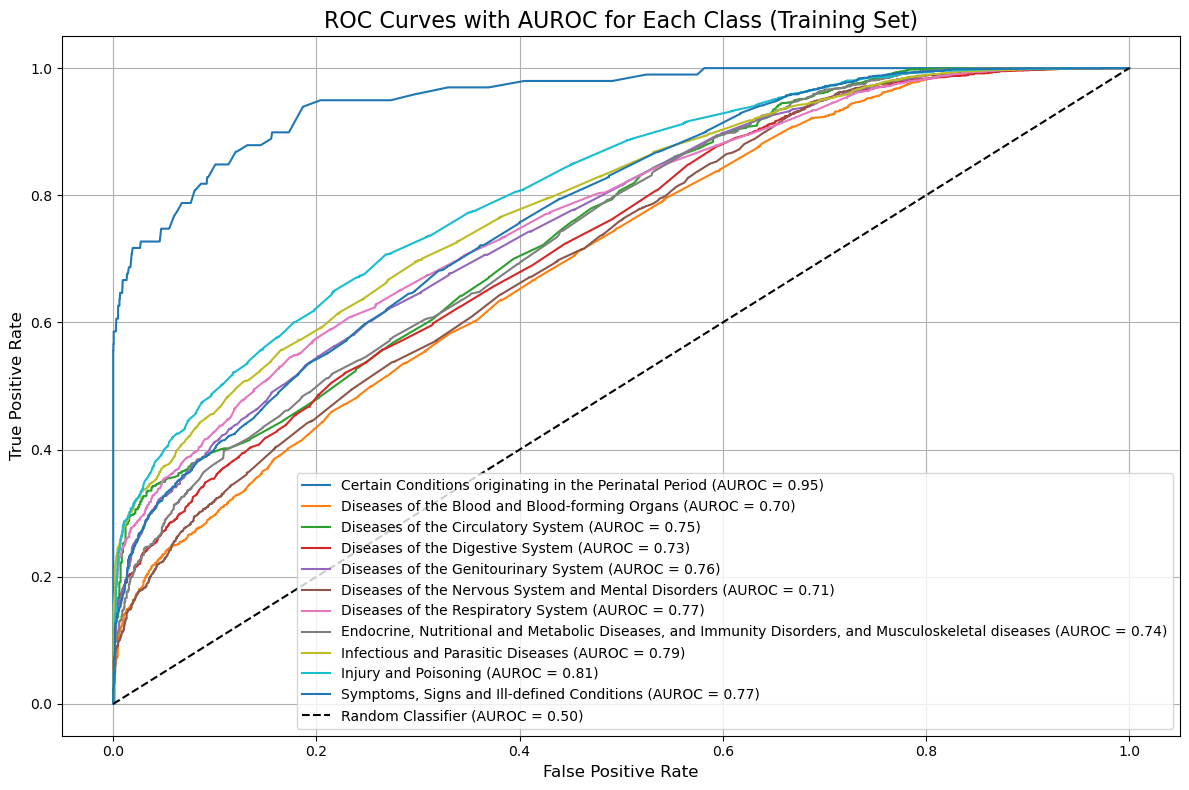


=== AUROC Values for Training Set ===
Certain Conditions originating in the Perinatal Period: 0.95
Diseases of the Blood and Blood-forming Organs: 0.70
Diseases of the Circulatory System: 0.75
Diseases of the Digestive System: 0.73
Diseases of the Genitourinary System: 0.76
Diseases of the Nervous System and Mental Disorders: 0.71
Diseases of the Respiratory System: 0.77
Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases: 0.74
Infectious and Parasitic Diseases: 0.79
Injury and Poisoning: 0.81
Symptoms, Signs and Ill-defined Conditions: 0.77
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


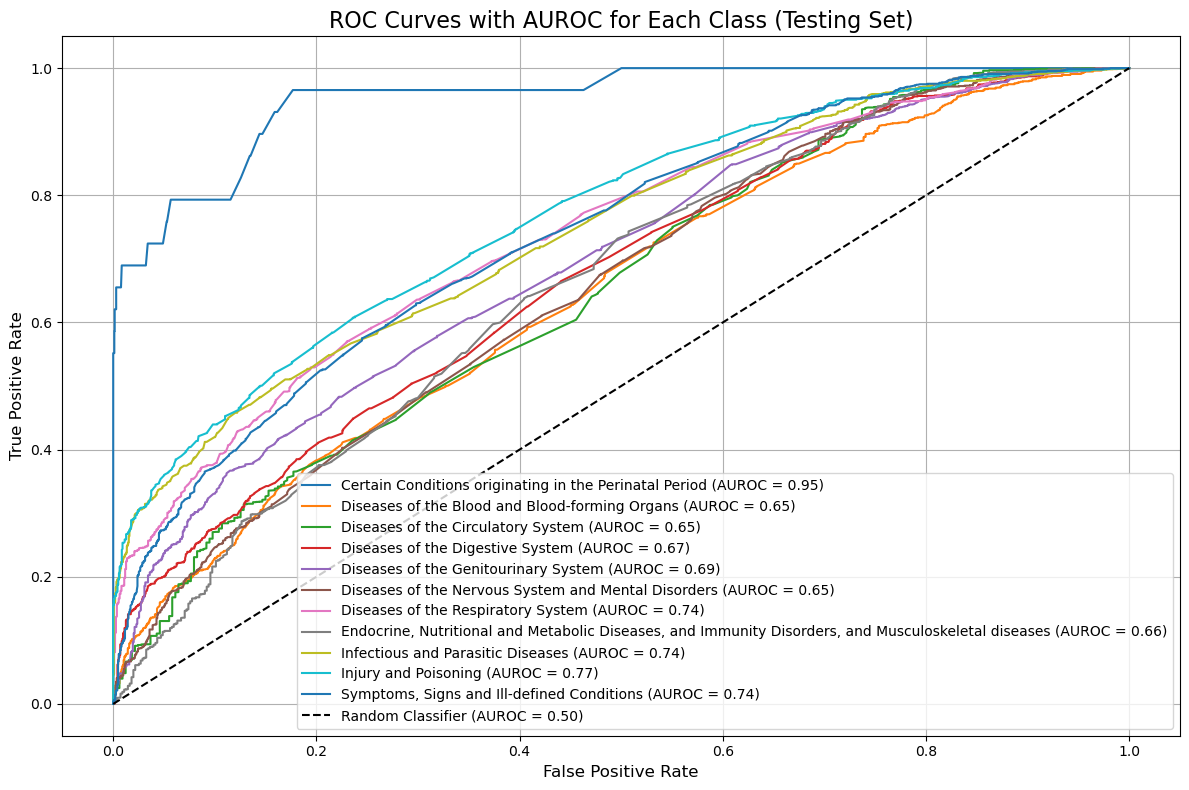


=== AUROC Values for Testing Set ===
Certain Conditions originating in the Perinatal Period: 0.95
Diseases of the Blood and Blood-forming Organs: 0.65
Diseases of the Circulatory System: 0.65
Diseases of the Digestive System: 0.67
Diseases of the Genitourinary System: 0.69
Diseases of the Nervous System and Mental Disorders: 0.65
Diseases of the Respiratory System: 0.74
Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, and Musculoskeletal diseases: 0.66
Infectious and Parasitic Diseases: 0.74
Injury and Poisoning: 0.77
Symptoms, Signs and Ill-defined Conditions: 0.74


In [233]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
 
# Function to compute and plot ROC curves and display AUROC values
def plot_roc_curve_with_auroc(y_true, y_pred_prob, class_names, dataset_name):
    plt.figure(figsize=(12, 8))
    auroc_values = {}
 
    for i, class_name in enumerate(class_names):
        # Compute ROC curve and AUROC
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        auroc = auc(fpr, tpr)
        auroc_values[class_name] = auroc
 
        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_name} (AUROC = {auroc:.2f})")
    # Plot random classifier line
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUROC = 0.50)")
    # Plot configuration
    plt.title(f"ROC Curves with AUROC for Each Class ({dataset_name})", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
 
    # Print AUROC values for each class
    print(f"\n=== AUROC Values for {dataset_name} ===")
    for class_name, auroc in auroc_values.items():
        print(f"{class_name}: {auroc:.2f}")
 
# Plot ROC curve with AUROC for the training set
y_train_pred_prob = fcnn_attention_model.predict(X_train)
plot_roc_curve_with_auroc(y_train, y_train_pred_prob, mlb.classes_, "Training Set")
 
# Plot ROC curve with AUROC for the testing set
y_test_pred_prob = fcnn_attention_model.predict(X_test)
plot_roc_curve_with_auroc(y_test, y_test_pred_prob, mlb.classes_, "Testing Set")

# FCNN Model Performance Tuning using Keras Tuner

In [234]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband
import joblib

# Assuming `chi2_scores` DataFrame is already available and sorted
# Extract the top 500 features
top_features = chi2_scores.head(20)['Feature'].tolist()

# Create Subset of Data Using Selected Features
X_selected = X_combined[:, [feature_names.index(f) for f in top_features]]

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_selected.toarray(), y_binary, test_size=0.3, random_state=42)

# Step 2: Define FCNN Model for Hyperparameter Tuning
def build_fcnn_model(hp):
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units_layer1", min_value=128, max_value=512, step=64),
            activation="relu",
            input_dim=X_train.shape[1],
        )
    )
    model.add(Dropout(hp.Float("dropout_layer1", min_value=0.2, max_value=0.5, step=0.1)))

    model.add(
        Dense(
            units=hp.Int("units_layer2", min_value=64, max_value=256, step=32),
            activation="relu",
        )
    )
    model.add(Dropout(hp.Float("dropout_layer2", min_value=0.2, max_value=0.5, step=0.1)))

    model.add(
        Dense(
            units=hp.Int("units_layer3", min_value=32, max_value=128, step=16),
            activation="relu",
        )
    )
    model.add(Dropout(hp.Float("dropout_layer3", min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(y_binary.shape[1], activation="sigmoid"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Step 3: Initialize and Run Keras Tuner
tuner = Hyperband(
    build_fcnn_model,
    objective="val_loss",
    max_epochs=30,
    factor=3,
    directory="fcnn_tuning",
    project_name="fcnn_hyperparam_tuning",
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Run Tuning
print("Starting Hyperparameter Tuning...")
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=128,
    verbose=1,
)

# Retrieve Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Hyperparameters: {best_hps.values}")

# Build and Train the Model with Best Hyperparameters
model = tuner.hypermodel.build(best_hps)

# Step 4: Train Model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1,
)

# Step 5: Evaluate Model
def evaluate_model(model, X, y_true, dataset_name):
    print(f"\n=== Evaluating on {dataset_name} Set ===")
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"\nHamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")
    return y_pred

# Training and Testing Evaluations
print("\nTraining Evaluation:")
y_train_pred = evaluate_model(model, X_train, y_train, "Training")

print("\nTesting Evaluation:")
y_test_pred = evaluate_model(model, X_test, y_test, "Testing")

# Save Results
print("\nSaving Tuned FCNN Model and Predictions...")
joblib.dump(model, "fcnn_tuned_model.pkl")
joblib.dump(y_train_pred, "fcnn_tuned_y_train_pred.pkl")
joblib.dump(y_test_pred, "fcnn_tuned_y_test_pred.pkl")
print("Results Saved Successfully.")

# Plot Training History
# def plot_training_history(history):
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(12, 6))
#     plt.plot(history.history["loss"], label="Training Loss")
#     plt.plot(history.history["val_loss"], label="Validation Loss")
#     plt.title("Training and Validation Loss (FCNN Tuned)")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# plot_training_history(history)

Reloading Tuner from fcnn_tuning\fcnn_hyperparam_tuning\tuner0.json
Starting Hyperparameter Tuning...

Best Hyperparameters: {'units_layer1': 384, 'dropout_layer1': 0.30000000000000004, 'units_layer2': 160, 'dropout_layer2': 0.2, 'units_layer3': 128, 'dropout_layer3': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}


C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0393 - loss: 0.6585 - val_accuracy: 0.4407 - val_loss: 0.5773
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4175 - loss: 0.5811 - val_accuracy: 0.4407 - val_loss: 0.5523
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4245 - loss: 0.5564 - val_accuracy: 0.4314 - val_loss: 0.5433
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3987 - loss: 0.5436 - val_accuracy: 0.4353 - val_loss: 0.5345
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3932 - loss: 0.5330 - val_accuracy: 0.4245 - val_loss: 0.5260
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4036 - loss: 0.5236 - val_accuracy: 0.4167 - val_loss: 0.5217
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3878 - loss: 0.5136 - val_accuracy: 0.4012 - val_loss: 0.5191
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3833 - loss: 0.5095 - val_accuracy: 0.3772 - val_loss

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


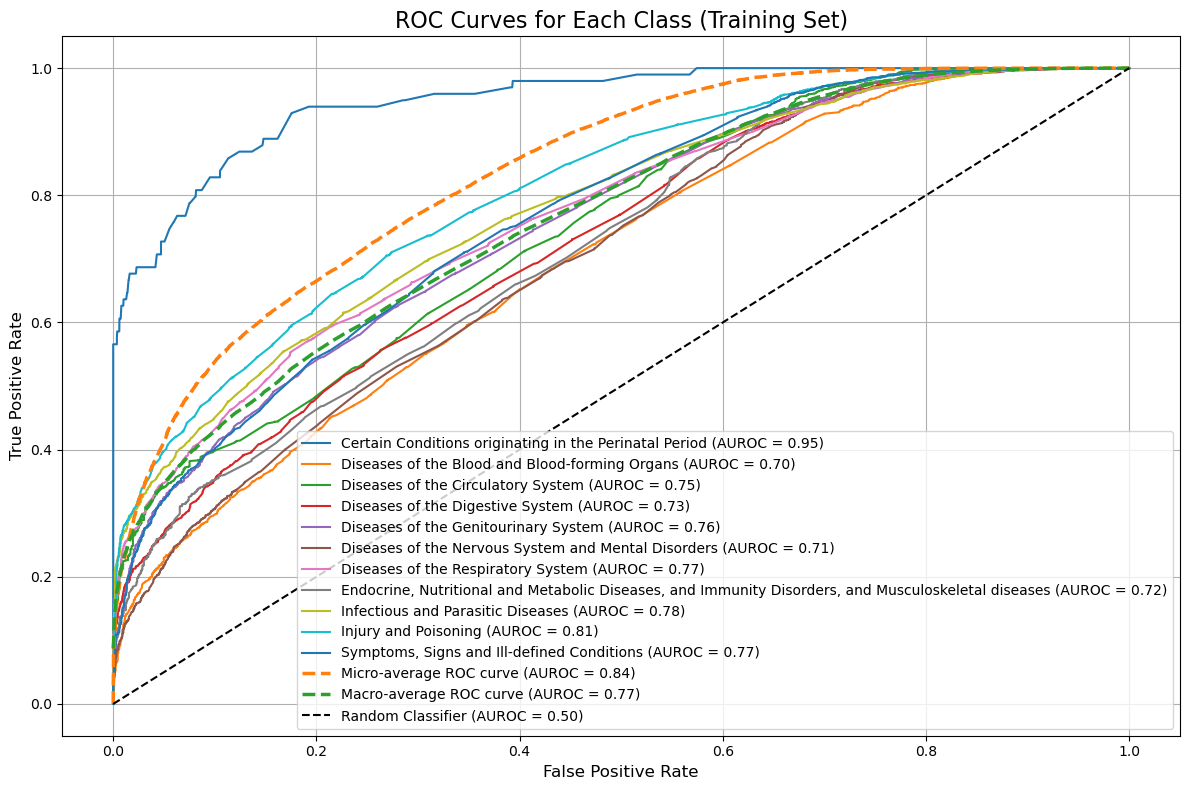

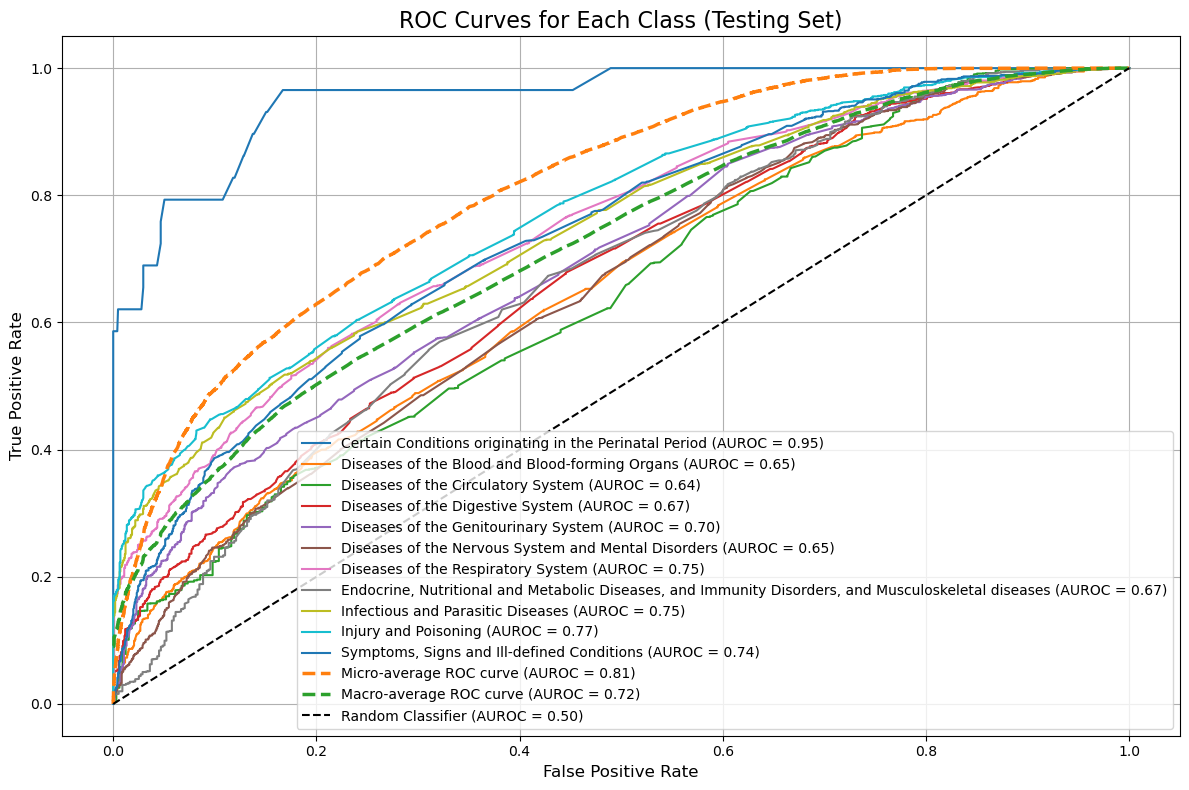

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  # auc function used to calculate AUROC
from sklearn.preprocessing import label_binarize

# Function to plot ROC curves including micro and macro-averaged curves
def plot_roc_curves(y_true, y_pred_prob, class_names, dataset_name):
    plt.figure(figsize=(12, 8))
    
    # Binarize the output for micro and macro averaging
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Variables to store micro and macro results
    all_fpr = np.unique(np.concatenate([roc_curve(y_true_bin[:, i], y_pred_prob[:, i])[0] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)  # Calculating AUROC for each class
        plt.plot(fpr, tpr, label=f"{class_name} (AUROC = {roc_auc:.2f})")

        # Interpolate mean TPR for micro-averaging
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Micro-average ROC curve and AUROC
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC curve (AUROC = {roc_auc_micro:.2f})", linestyle='--', linewidth=2.5)

    # Macro-average ROC curve and AUROC
    mean_tpr /= len(class_names)
    roc_auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC curve (AUROC = {roc_auc_macro:.2f})", linestyle='--', linewidth=2.5)

    # Plot random classifier line
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUROC = 0.50)")

    # Plot configuration
    plt.title(f"ROC Curves for Each Class ({dataset_name})", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Predictions for training set
y_train_pred_prob = model.predict(X_train)

# Predictions for testing set
y_test_pred_prob = model.predict(X_test)

# Generate ROC curves for the training set
plot_roc_curves(y_train, y_train_pred_prob, mlb.classes_, "Training Set")

# Generate ROC curves for the testing set
plot_roc_curves(y_test, y_test_pred_prob, mlb.classes_, "Testing Set")


# BEST WORKING MODEL --> FCNN with Attention mechanism hyperparmater tuning using Keras Tuner

Trial 90 Complete [00h 00m 13s]
val_loss: 0.5113935470581055

Best val_loss So Far: 0.5097554326057434
Total elapsed time: 00h 07m 29s

Best Hyperparameters: {'units_layer1': 448, 'dropout_layer1': 0.4, 'units_layer2': 96, 'dropout_layer2': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0079'}
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1028 - loss: 0.8894 - val_accuracy: 0.4268 - val_loss: 0.6588
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0936 - loss: 0.7260 - val_accuracy: 0.4400 - val_loss: 0.6336
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1204 - loss: 0.6581 - val_accuracy: 0.4407 - val_loss: 0.6105
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1470 - loss: 0.6147 - val_accuracy: 0.4415 - val_loss: 0.5928
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1995 - loss: 0.5826 - val_accuracy: 0.4438 - val_l

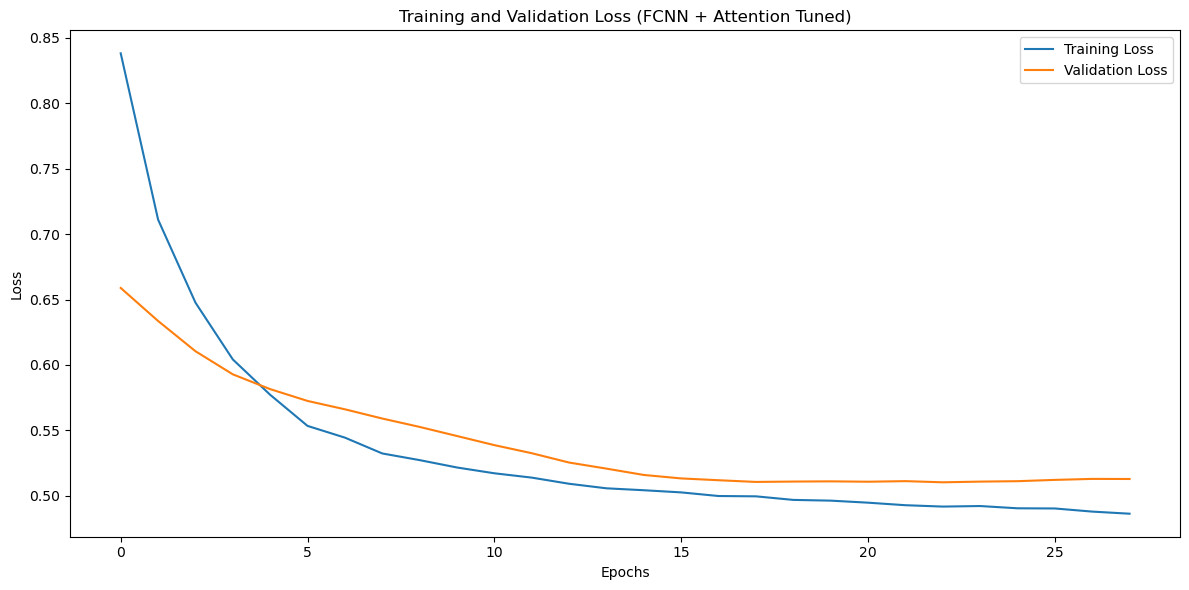

In [100]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Input, BatchNormalization, Attention, Add
)
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import Hyperband
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split
import joblib
 
# Assuming `chi2_scores` and other data preparations are already available
top_features = chi2_scores.head(20)['Feature'].tolist()
X_selected = X_combined[:, [feature_names.index(f) for f in top_features]]
 
# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected.toarray(), y_binary, test_size=0.3, random_state=42
)
 
# Step 2: Define FCNN + Attention Model with Hyperparameter Tuning
def build_fcnn_attention_model(hp):
    inputs = Input(shape=(X_train.shape[1],))
 
    # Fully Connected Layer 1
    dense1 = Dense(
        units=hp.Int("units_layer1", min_value=128, max_value=512, step=64),
        activation="relu",
    )(inputs)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(hp.Float("dropout_layer1", min_value=0.2, max_value=0.5, step=0.1))(bn1)
 
    # Fully Connected Layer 2
    dense2 = Dense(
        units=hp.Int("units_layer2", min_value=64, max_value=256, step=32),
        activation="relu",
    )(dropout1)
    bn2 = BatchNormalization()(dense2)
    dropout2 = Dropout(hp.Float("dropout_layer2", min_value=0.2, max_value=0.5, step=0.1))(bn2)
 
    # Attention Mechanism
    attention_weights = Dense(dropout2.shape[-1], activation="softmax")(dropout2)  # Match shape
    attention_output = Add()([dropout2, attention_weights])
 
    # Output Layer
    outputs = Dense(y_binary.shape[1], activation="sigmoid")(attention_output)
 
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model
 
# Step 3: Initialize Keras Tuner
tuner = Hyperband(
    build_fcnn_attention_model,
    objective="val_loss",
    max_epochs=30,
    factor=3,
    directory="fcnn_attention_tuning",
    project_name="fcnn_attention_hyperparam_tuning",
)
 
# Step 4: Run Hyperparameter Tuning
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
 
print("Starting Hyperparameter Tuning...")
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=128,
    verbose=1,
)
 
# Step 5: Retrieve Best Hyperparameters and Train Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Hyperparameters: {best_hps.values}")
 
model = tuner.hypermodel.build(best_hps)
 
# Train the model with best hyperparameters
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1,
)
 
# Step 6: Evaluate Model
def evaluate_model(model, X, y_true, dataset_name):
    print(f"\n=== Evaluating on {dataset_name} Set ===")
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"\nHamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")
    return y_pred
 
# Training and Testing Evaluations
print("\nTraining Evaluation:")
y_train_pred = evaluate_model(model, X_train, y_train, "Training")
 
print("\nTesting Evaluation:")
y_test_pred = evaluate_model(model, X_test, y_test, "Testing")
 
# Step 7: Save Results
print("\nSaving Tuned FCNN + Attention Model and Predictions...")
joblib.dump(model, "fcnn_attention_tuned_model.pkl")
joblib.dump(y_train_pred, "fcnn_attention_tuned_y_train_pred.pkl")
joblib.dump(y_test_pred, "fcnn_attention_tuned_y_test_pred.pkl")
print("Results Saved Successfully.")
 
# Plot Training History (Optional)
def plot_training_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss (FCNN + Attention Tuned)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
 
plot_training_history(history)

# ROC curve for the FCNN With Attention mechanism Tuned using Keras Tuner model (Best working mdoel)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


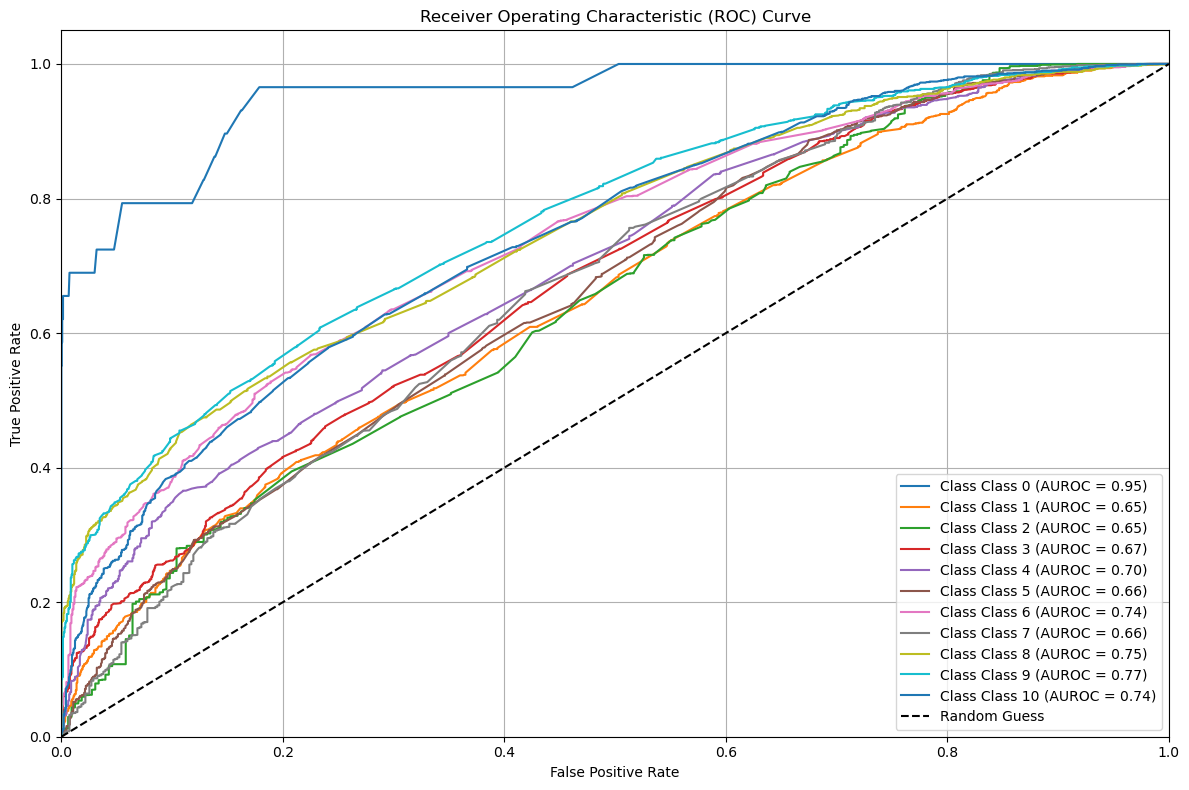


=== AUROC Scores ===
Class 0: 0.9534
Class 1: 0.6493
Class 2: 0.6465
Class 3: 0.6740
Class 4: 0.6958
Class 5: 0.6590
Class 6: 0.7391
Class 7: 0.6646
Class 8: 0.7488
Class 9: 0.7665
Class 10: 0.7411


In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
 
# Function to plot ROC curve and calculate AUROC for each label
def plot_roc_curve(y_true, y_pred_prob, class_names):
    n_classes = y_true.shape[1]  # Number of classes
    plt.figure(figsize=(12, 8))
    # Dictionary to store AUROC values for each class
    auroc_scores = {}
    # Generate ROC curve and AUROC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        auroc_scores[class_names[i]] = roc_auc  # Save AUROC for this class
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUROC = {roc_auc:.2f})")
    # Plot baseline (random guess)
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()
    return auroc_scores
 
# Predict probabilities on the test set
y_pred_prob = model.predict(X_test)
 
# Define class names (replace `mlb.classes_` with your actual class names if defined)
class_names = [f"Class {i}" for i in range(y_test.shape[1])]
 
# Plot ROC curve and calculate AUROC
auroc_scores = plot_roc_curve(y_test, y_pred_prob, class_names)
 
# Print AUROC scores for each class
print("\n=== AUROC Scores ===")
for class_name, score in auroc_scores.items():
    print(f"{class_name}: {score:.4f}")

# RANDOM SEARCH + FCNN + ATTENTION

In [125]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Add, Attention, Reshape, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split
import random
import joblib

# Assuming `chi2_scores` DataFrame is already available and sorted
# Extract the top 500 features
top_features = chi2_scores.head(20)['Feature'].tolist()

# Create Subset of Data Using Selected Features
X_selected = X_combined[:, [feature_names.index(f) for f in top_features]]

# Step 1: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_selected.toarray(), y_binary, test_size=0.3, random_state=42)

# Define the FCNN+Attention Model
def build_fcnn_attention_model(input_dim, output_units, units, dropout_rate, attention_heads):
    input_layer = Input(shape=(input_dim,))
    dense_1 = Dense(units[0], activation='relu')(input_layer)
    dropout_1 = Dropout(dropout_rate[0])(dense_1)
    
    dense_2 = Dense(units[1], activation='relu')(dropout_1)
    dropout_2 = Dropout(dropout_rate[1])(dense_2)
    
    dense_3 = Dense(units[2], activation='relu')(dropout_2)
    dropout_3 = Dropout(dropout_rate[2])(dense_3)

    # Reshape for Attention
    attention_input = Reshape((-1, 1))(dropout_3)

    # Attention Mechanism
    query = Dense(attention_heads, activation='relu')(attention_input)
    key = Dense(attention_heads, activation='relu')(attention_input)
    value = Dense(attention_heads, activation='relu')(attention_input)
    attention_output = Attention()([query, key, value])

    # Flatten Attention Output using Lambda Layer
    attention_flattened = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention_output)

    # Align dimensions of dropout_3 and attention_flattened for addition
    dropout_3_reshaped = Dense(attention_heads, activation='relu')(dropout_3)
    combined = Add()([dropout_3_reshaped, attention_flattened])  # Add residual connection

    output_layer = Dense(output_units, activation='sigmoid')(combined)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the Random Search Hyperparameter Tuning
def random_search_fcnn_attention(X_train, y_train, input_dim, output_units, num_combinations=10):
    best_model = None
    best_loss = float('inf')
    best_params = None

    for _ in range(num_combinations):
        # Randomly sample hyperparameters
        units = [random.choice([128, 256, 512]), random.choice([64, 128, 256]), random.choice([32, 64, 128])]
        dropout_rate = [random.uniform(0.2, 0.5) for _ in range(3)]
        attention_heads = random.choice([8, 16, 32])

        print(f"\nTesting Combination: Units={units}, Dropout Rates={dropout_rate}, Attention Heads={attention_heads}")

        # Build and train the model
        model = build_fcnn_attention_model(input_dim, output_units, units, dropout_rate, attention_heads)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=30,
            batch_size=128,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        val_loss = min(history.history['val_loss'])
        print(f"Validation Loss: {val_loss}")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = {"units": units, "dropout_rate": dropout_rate, "attention_heads": attention_heads}

    print(f"\nBest Parameters: {best_params}")
    return best_model, best_params

# Initialize Random Search
input_dim = X_train.shape[1]
output_units = y_binary.shape[1]
best_model, best_params = random_search_fcnn_attention(X_train, y_train, input_dim, output_units)

# Evaluate Best Model
def evaluate_model(model, X, y_true, dataset_name):
    print(f"\n=== Evaluating on {dataset_name} Set ===")
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))
    print(f"\nHamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred)}")
    print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred)}")
    return y_pred

print("\nTraining Evaluation:")
y_train_pred = evaluate_model(best_model, X_train, y_train, "Training")

print("\nTesting Evaluation:")
y_test_pred = evaluate_model(best_model, X_test, y_test, "Testing")

# Save Results
print("\nSaving Best FCNN+Attention Model and Predictions...")
joblib.dump(best_model, "fcnn_attention_best_model.pkl")
joblib.dump(y_train_pred, "fcnn_attention_y_train_pred.pkl")
joblib.dump(y_test_pred, "fcnn_attention_y_test_pred.pkl")
print("Results Saved Successfully.")


Testing Combination: Units=[128, 64, 64], Dropout Rates=[0.29216725798979903, 0.22987822082746762, 0.4353191215223535], Attention Heads=16

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0314 - loss: 0.6845 - val_accuracy: 0.4400 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2069 - loss: 0.6121 - val_accuracy: 0.4407 - val_loss: 0.5834 - learning_rate: 0.0010
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4090 - loss: 0.5929 - val_accuracy: 0.4407 - val_loss: 0.5795 - learning_rate: 0.0010
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4197 - loss: 0.5869 - val_accuracy: 0.4407 - val_loss: 0.5769 - learning_rate: 0.0010
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4372 - loss: 0.5820 - val_accuracy: 0.4407 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4290 - loss: 0.5774 - val_accuracy: 0.4407 - 

# Wide and deep network

In [126]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split
# Step 1: Prepare Data
# Assuming `chi2_scores` and `X_combined` are available
top_features = chi2_scores.head(20)['Feature'].tolist()
X_selected = X_combined[:, [feature_names.index(f) for f in top_features]].toarray()
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_binary, test_size=0.3, random_state=42)
# Step 2: Define Wide and Deep Model
def build_wide_and_deep(input_dim, output_units):
   # Wide Input
   wide_input = Input(shape=(input_dim,), name="wide_input")
   # Deep Input
   deep_input = Input(shape=(input_dim,), name="deep_input")
   dense_1 = Dense(256, activation='relu')(deep_input)
   dropout_1 = Dropout(0.3)(dense_1)
   dense_2 = Dense(128, activation='relu')(dropout_1)
   dropout_2 = Dropout(0.3)(dense_2)
   dense_3 = Dense(64, activation='relu')(dropout_2)
   dropout_3 = Dropout(0.3)(dense_3)
   # Concatenate Wide and Deep
   combined = Concatenate()([wide_input, dropout_3])
   # Output Layer
   output_layer = Dense(output_units, activation='sigmoid')(combined)
   # Build Model
   model = Model(inputs=[wide_input, deep_input], outputs=output_layer)
   model.compile(
       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
       loss='binary_crossentropy',
       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
   )
   return model
# Step 3: Initialize Model
input_dim = X_train.shape[1]
output_units = y_train.shape[1]
wide_deep_model = build_wide_and_deep(input_dim, output_units)
# Step 4: Train Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
history = wide_deep_model.fit(
   [X_train, X_train], y_train,
   validation_split=0.2,
   epochs=50,
   batch_size=128,
   callbacks=[early_stopping, reduce_lr],
   verbose=1
)
# Step 5: Evaluate Model
def evaluate_model(model, X, y_true, dataset_name):
   print(f"\n=== Evaluating on {dataset_name} Set ===")
   y_pred_prob = model.predict([X, X])
   y_pred = (y_pred_prob > 0.5).astype(int)
   print(f"\nClassification Report ({dataset_name}):")
   report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
   print(classification_report(y_true, y_pred, zero_division=0))
   print(f"\nHamming Loss ({dataset_name}): {hamming_loss(y_true, y_pred):.4f}")
   print(f"Accuracy ({dataset_name}): {accuracy_score(y_true, y_pred):.4f}")
   return report, y_pred
print("\nTraining Evaluation:")
train_report, y_train_pred = evaluate_model(wide_deep_model, X_train, y_train, "Training")
print("\nTesting Evaluation:")
test_report, y_test_pred = evaluate_model(wide_deep_model, X_test, y_test, "Testing")
# Step 6: Save Model and Metrics (Optional)
# wide_deep_model.save("wide_and_deep_model.h5")
# np.save("y_train_pred.npy", y_train_pred)
# np.save("y_test_pred.npy", y_test_pred)

Epoch 1/50


C:\Users\SnehalChoudhari-I\anaconda3_new\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['wide_input', 'deep_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2257 - loss: 0.6754 - precision: 0.6022 - recall: 0.6715 - val_accuracy: 0.4407 - val_loss: 0.5871 - val_precision: 0.6518 - val_recall: 0.6698 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4264 - loss: 0.5897 - precision: 0.6401 - recall: 0.7015 - val_accuracy: 0.4407 - val_loss: 0.5782 - val_precision: 0.6793 - val_recall: 0.6285 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4282 - loss: 0.5826 - precision: 0.6500 - recall: 0.6847 - val_accuracy: 0.4407 - val_loss: 0.5632 - val_precision: 0.6662 - val_recall: 0.7781 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4269 - loss: 0.5621 - precision: 0.6716 - recall: 0.7443 - val_accuracy: 0.4299 - val_loss: 0.5469 - val_precision: 0.7179 - val_recall: 0.6613 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4106 - loss: 0.5503